In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import ks_2samp, mannwhitneyu
import string

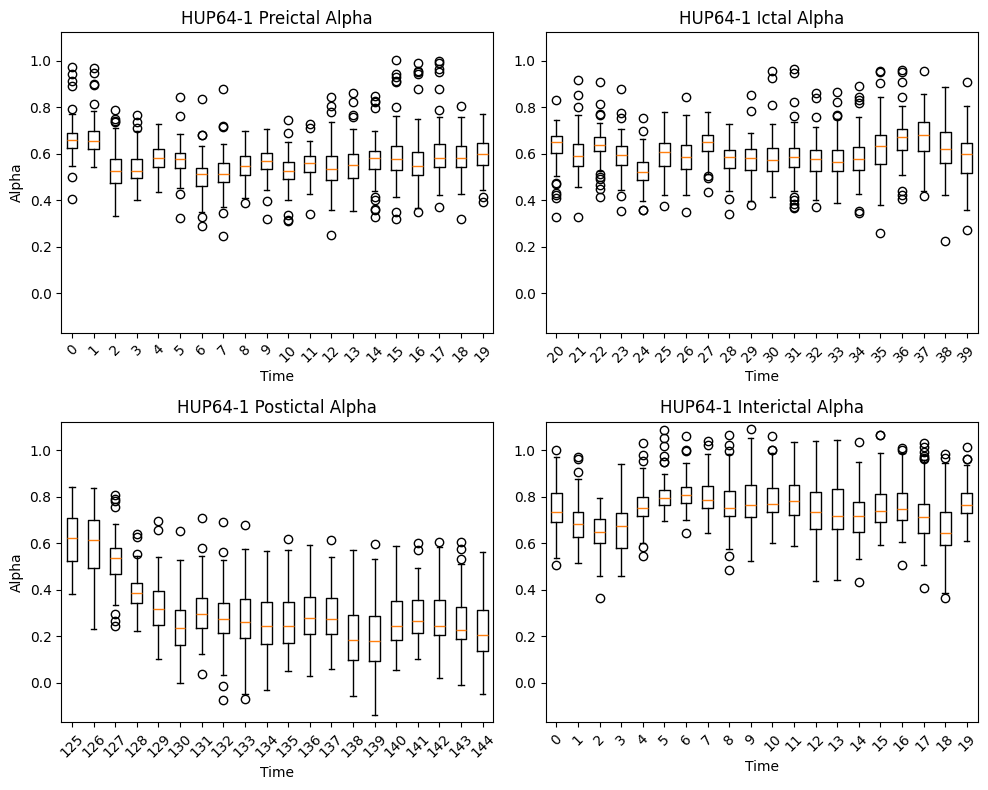

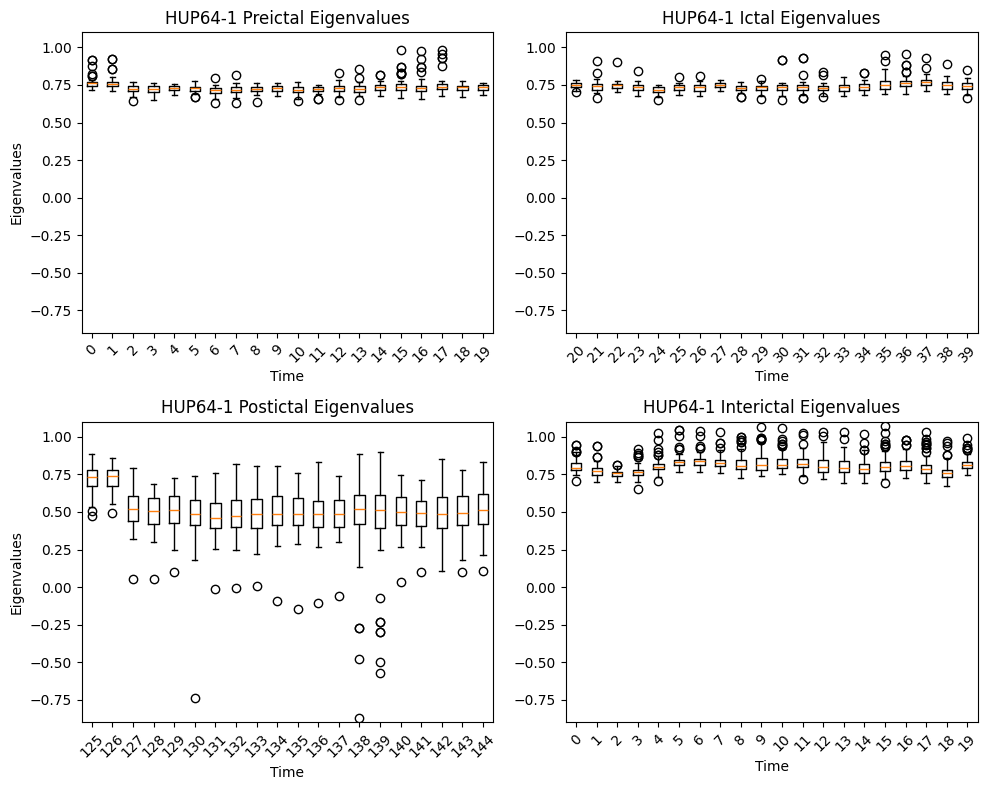

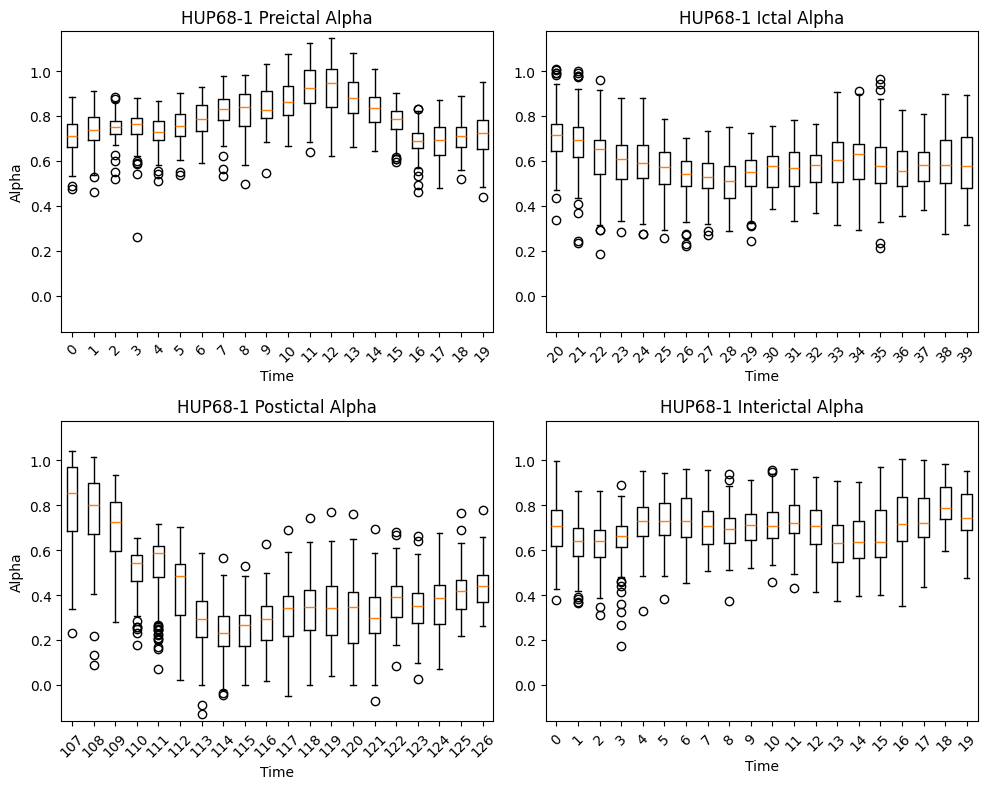

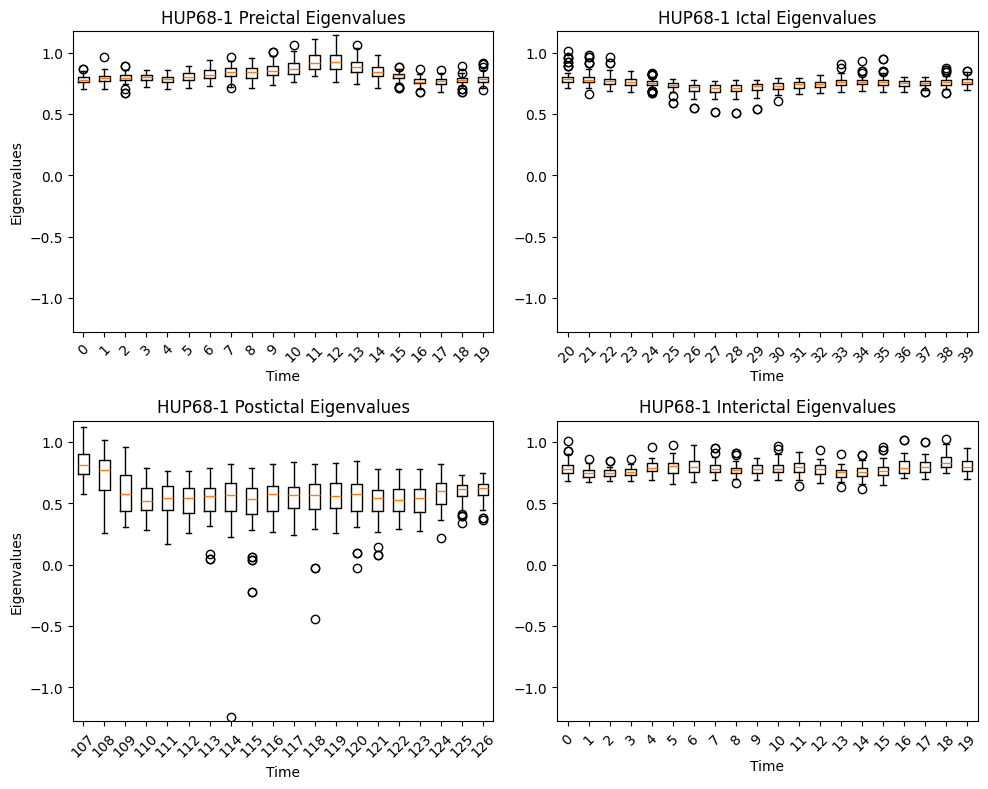

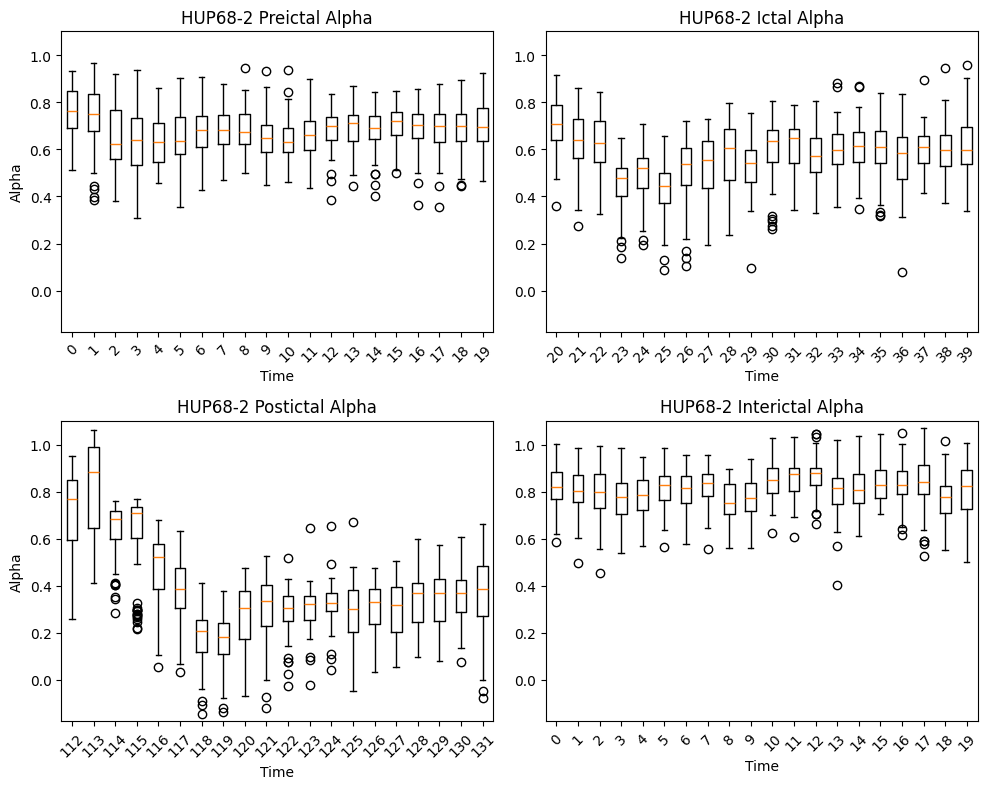

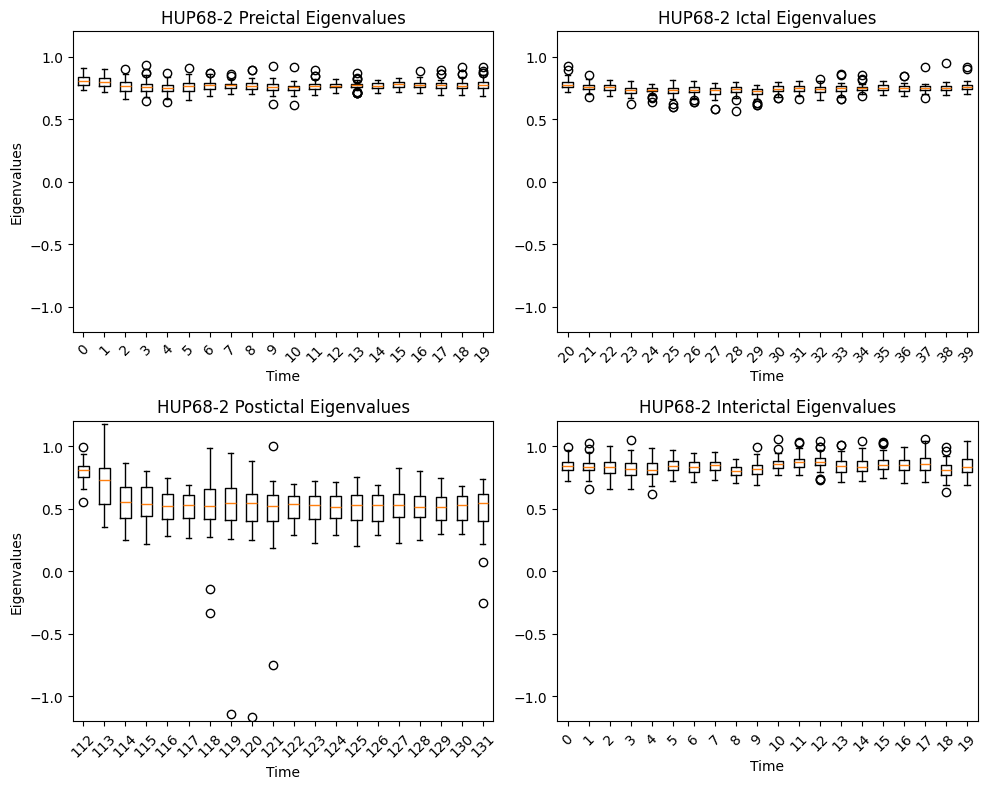

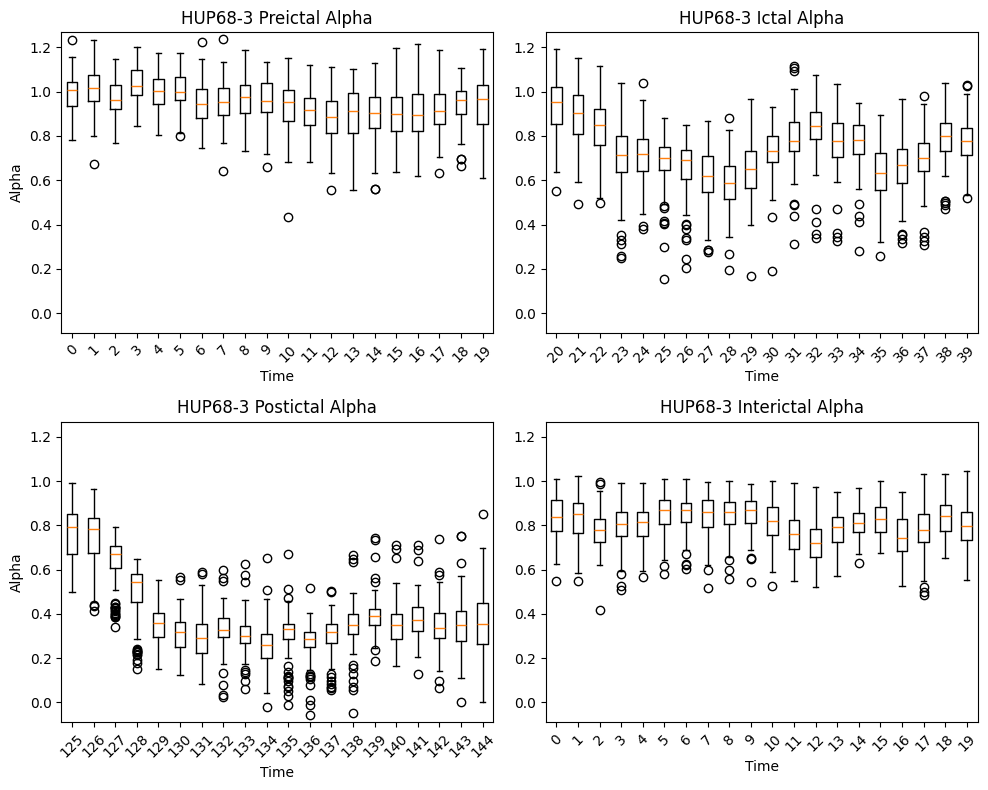

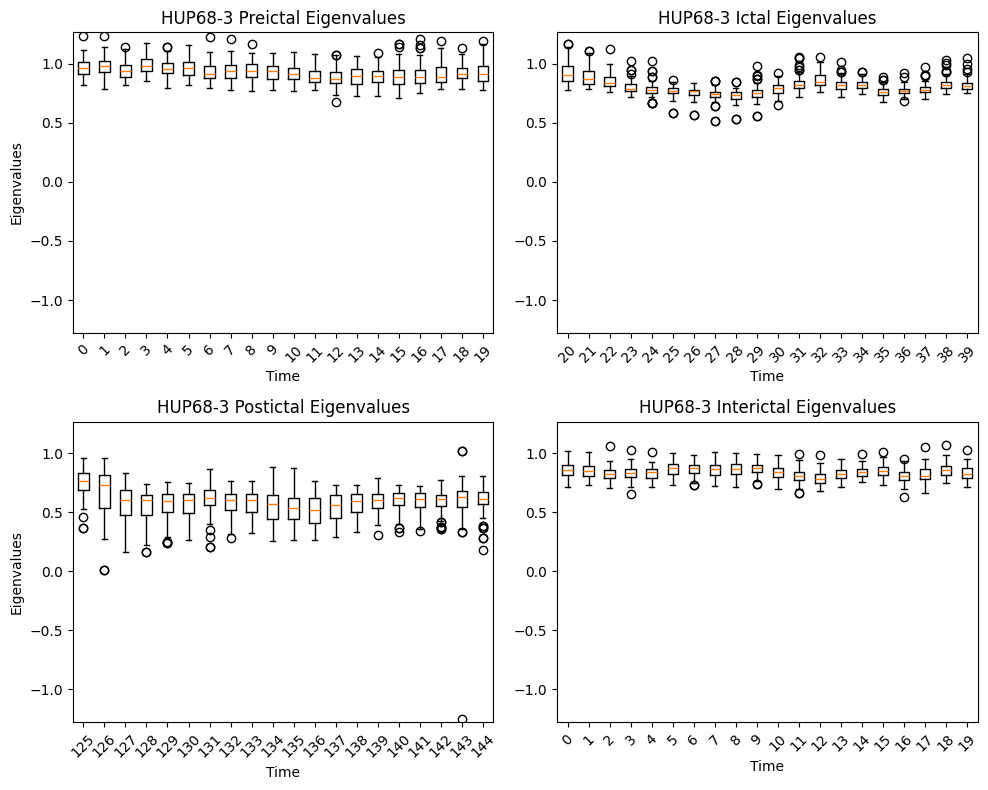

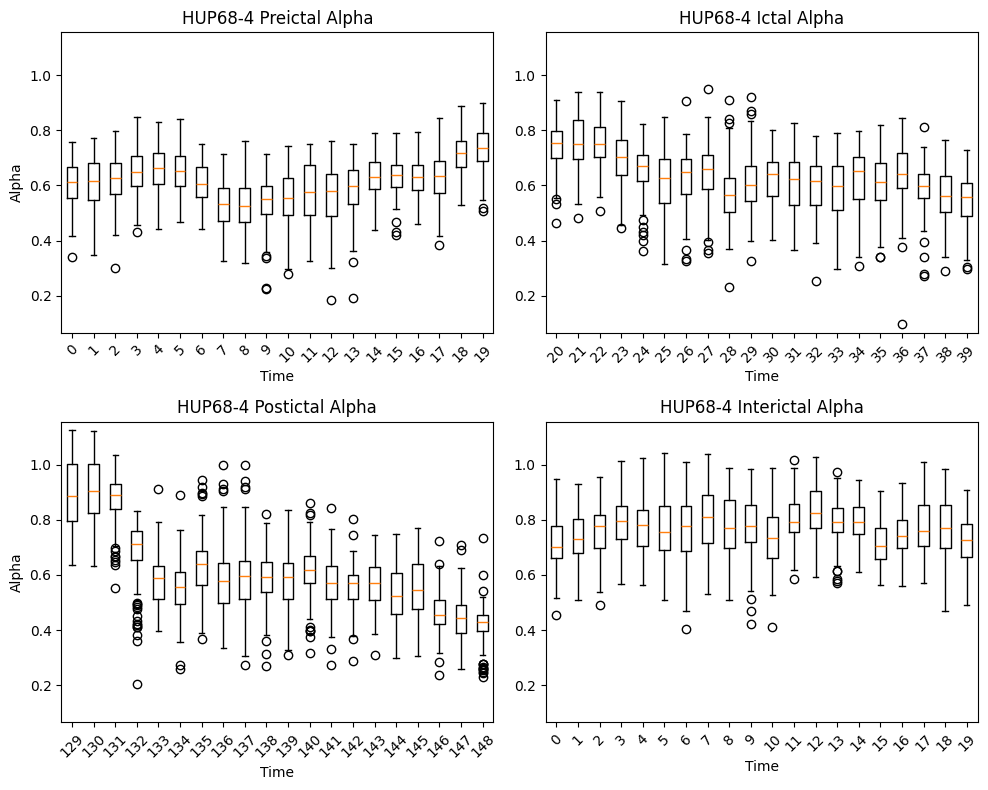

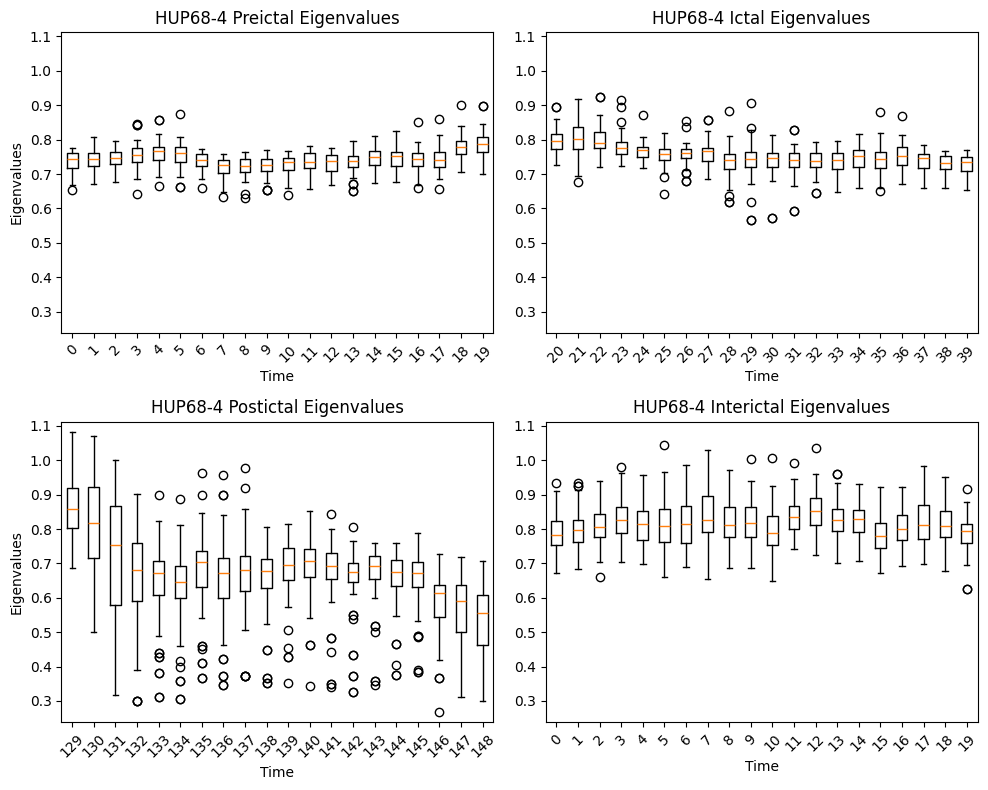

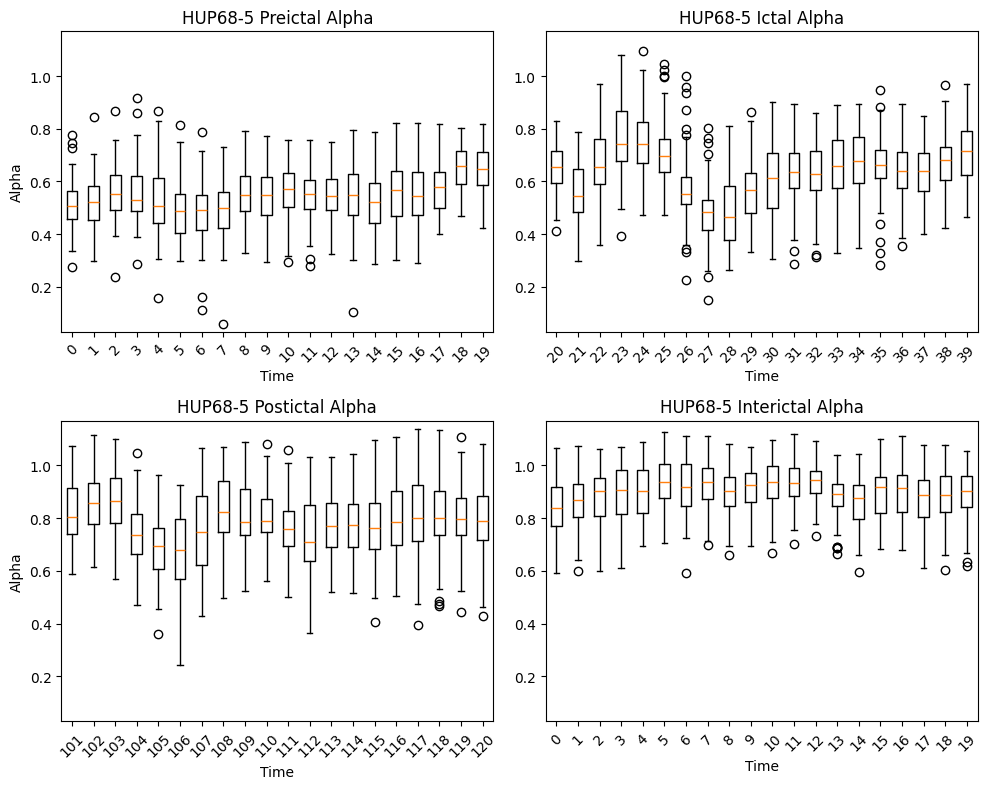

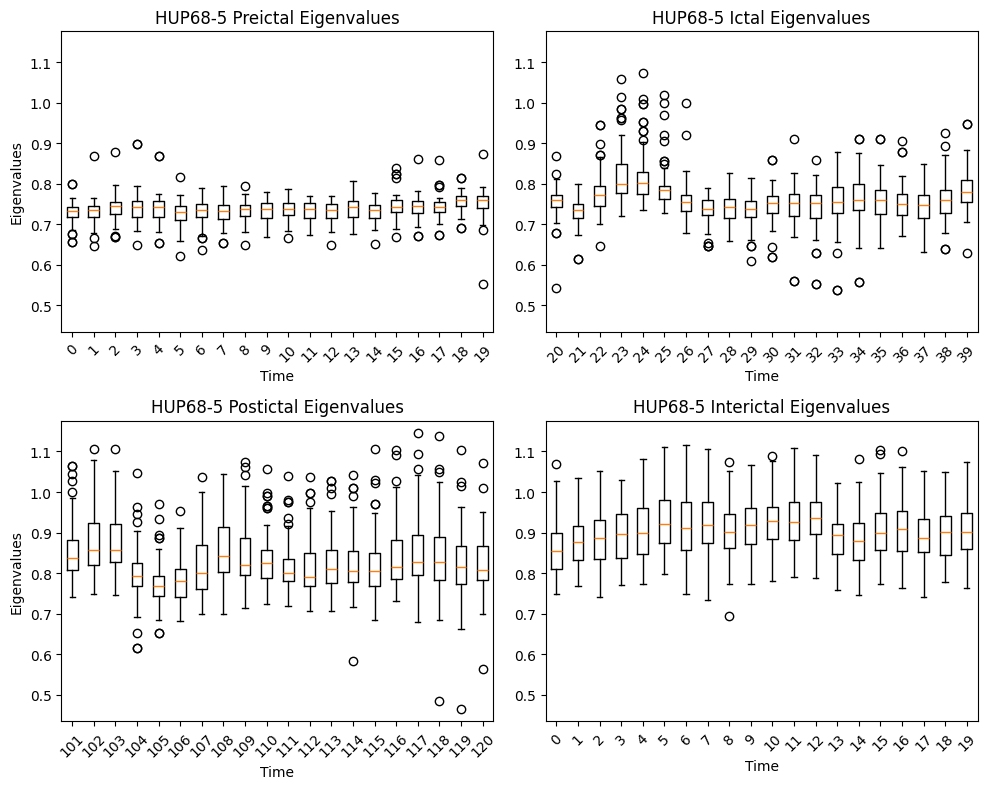

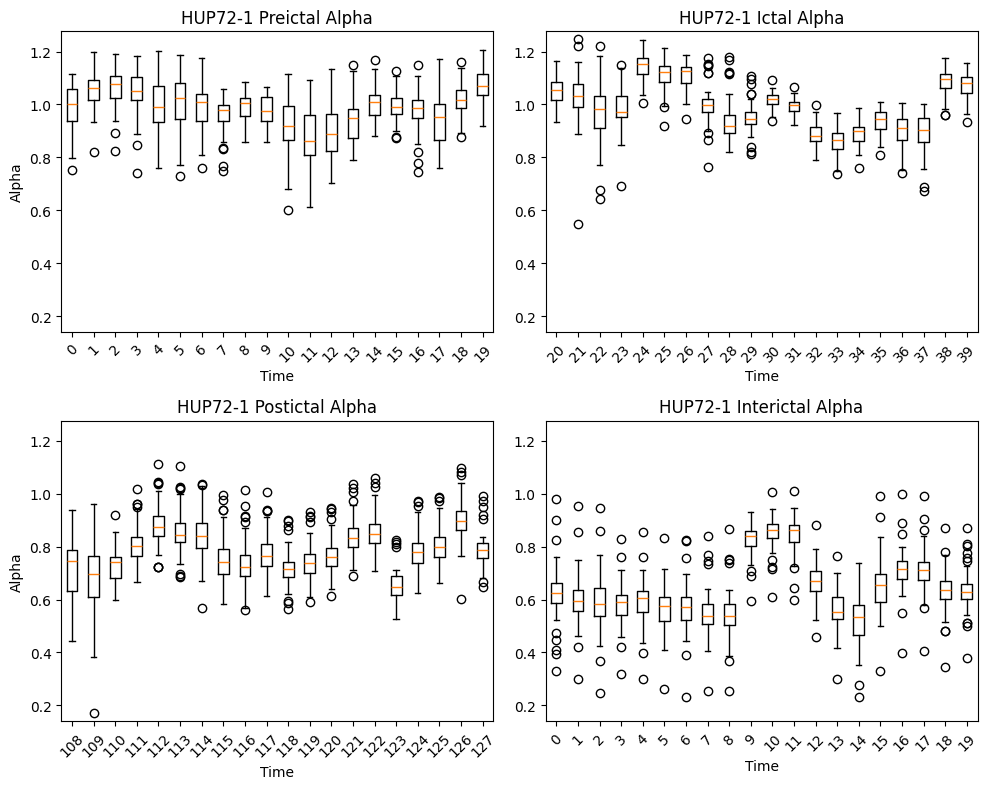

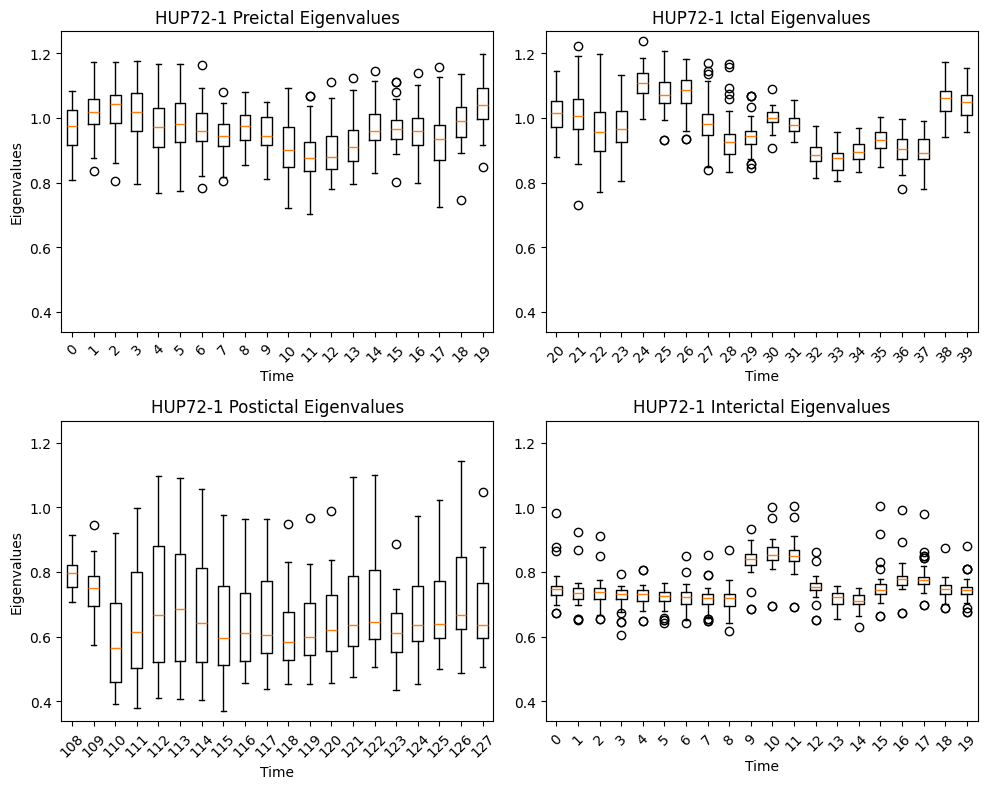

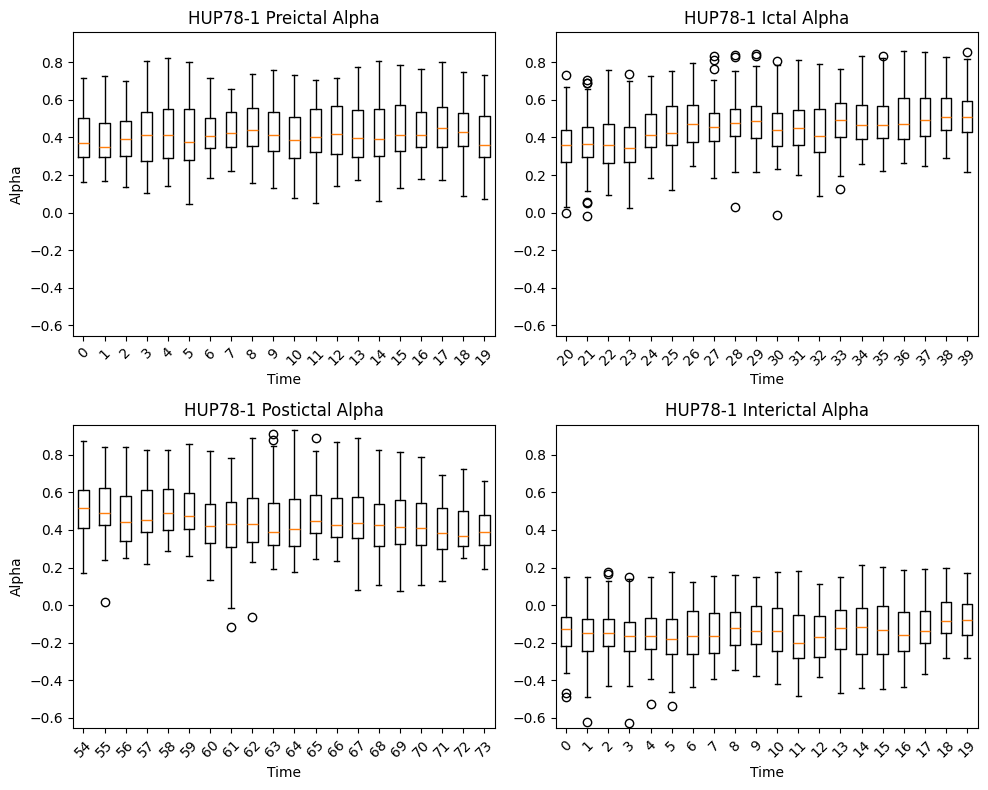

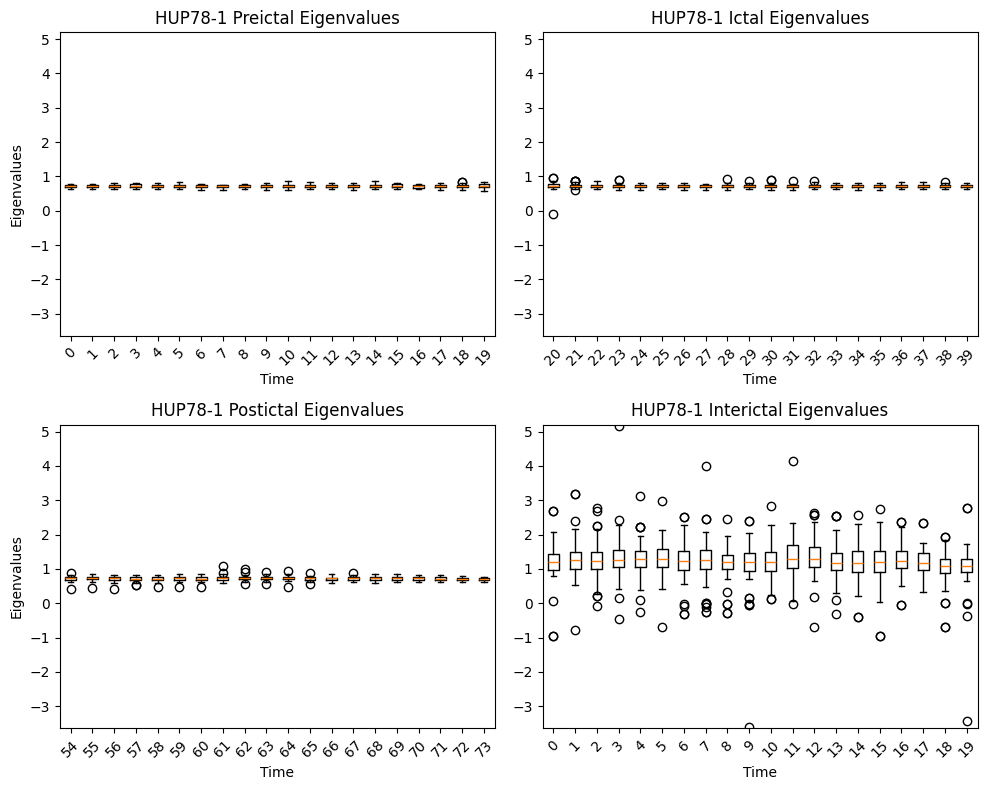

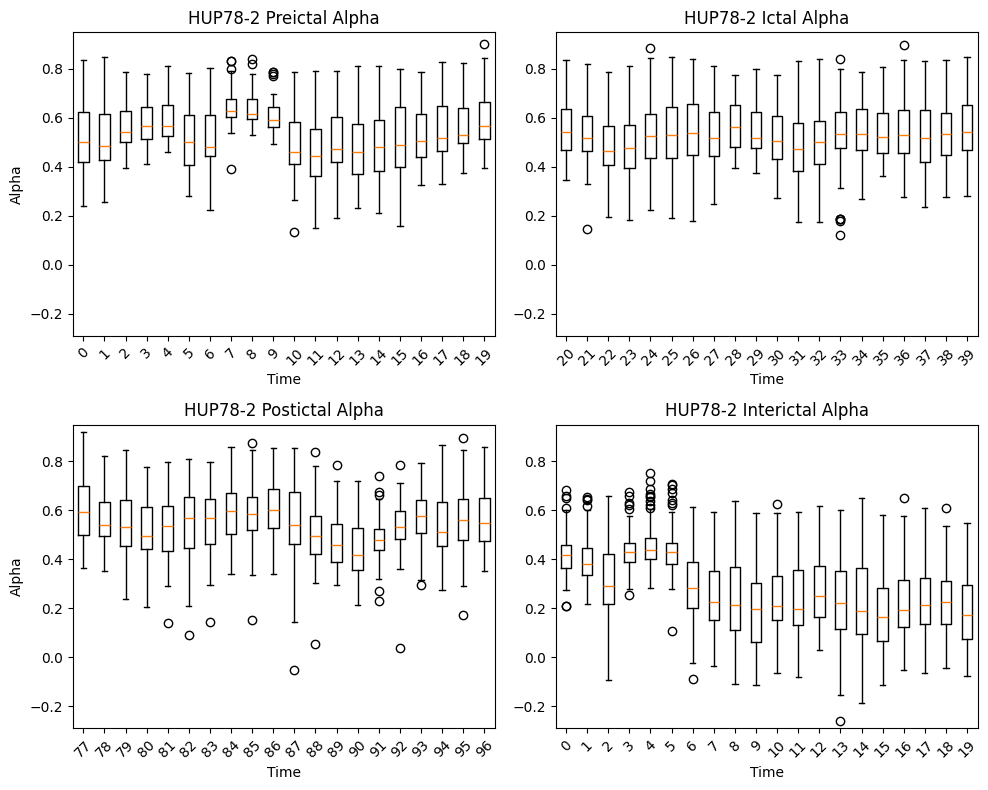

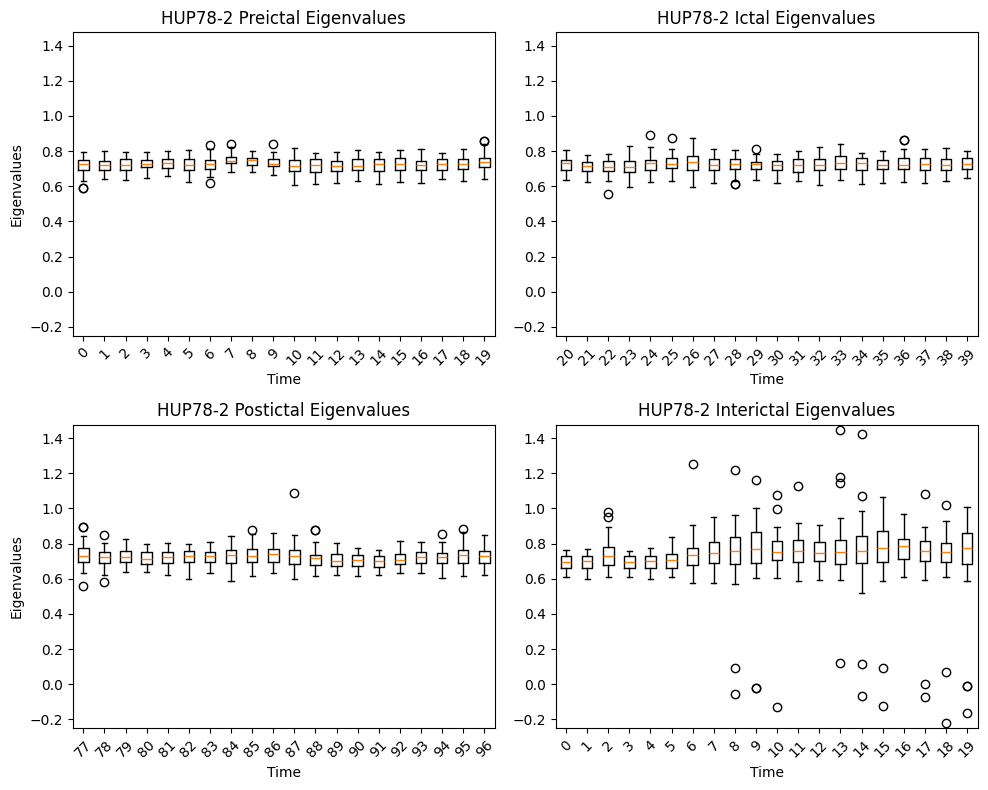

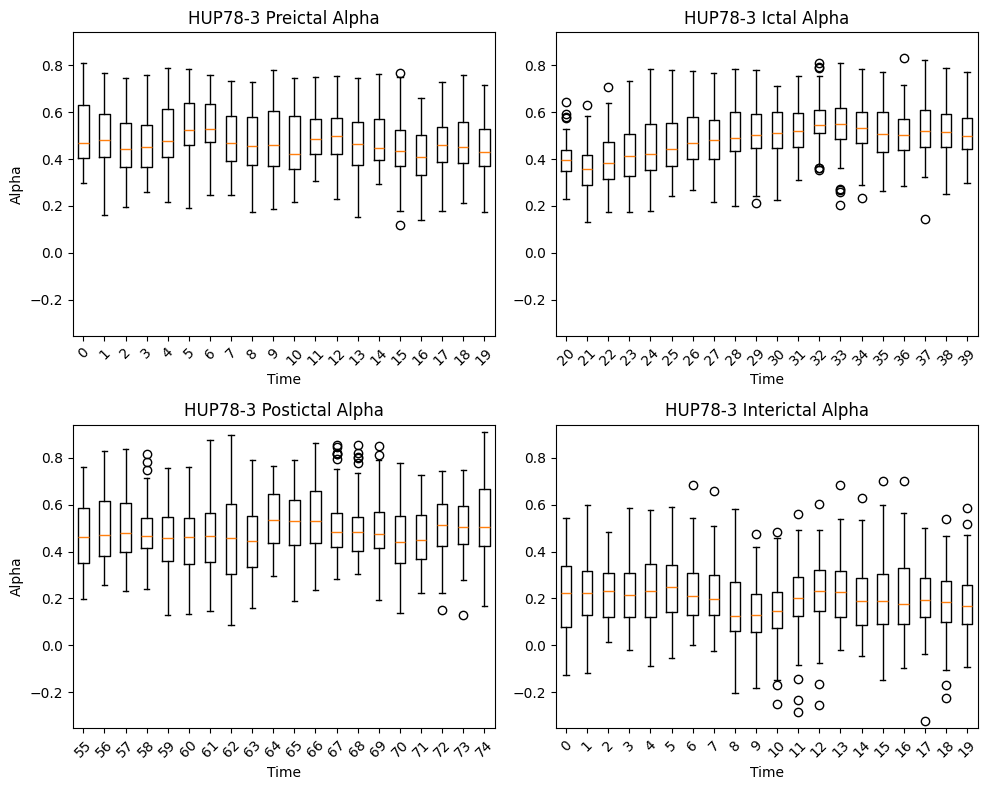

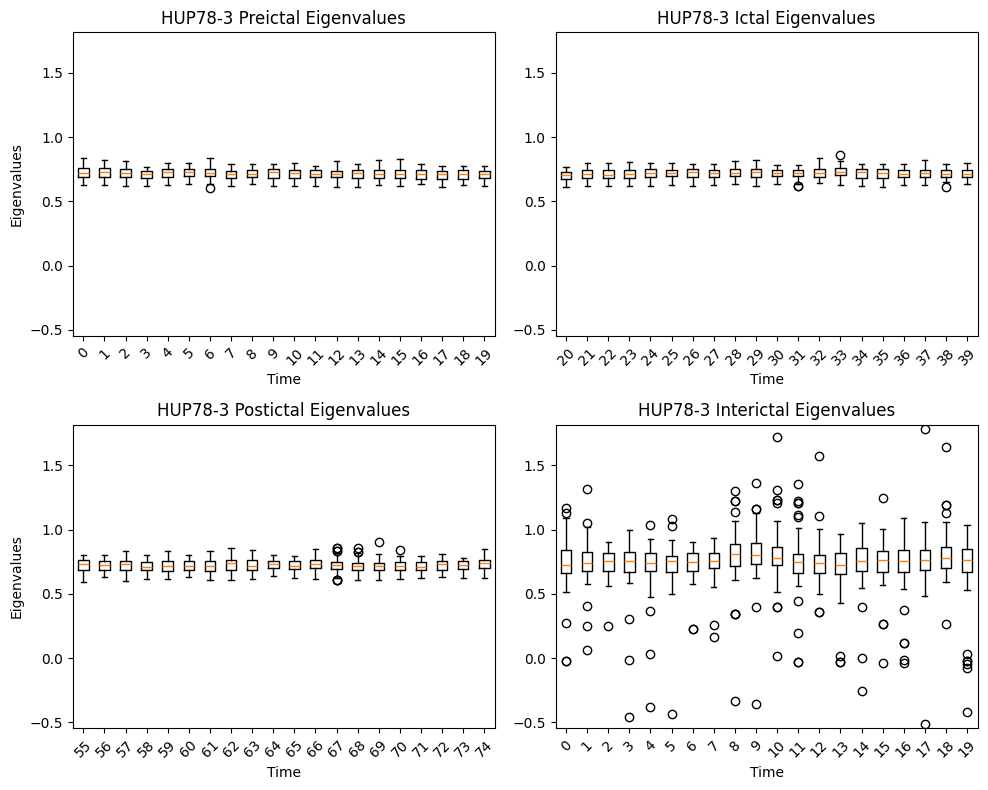

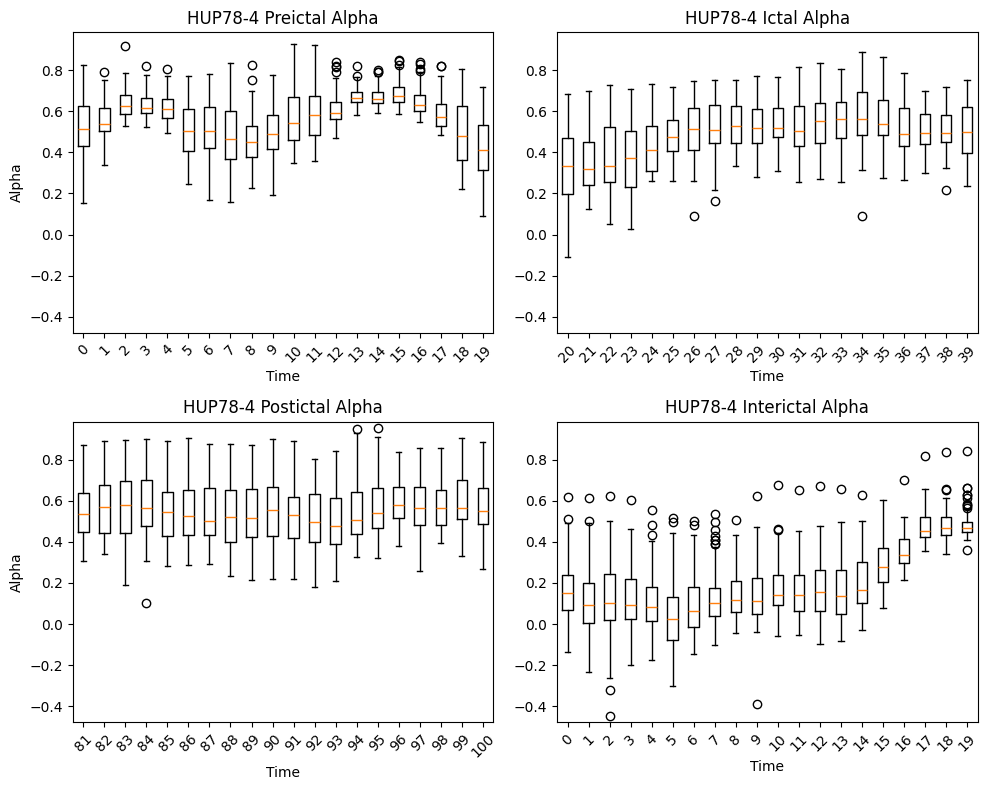

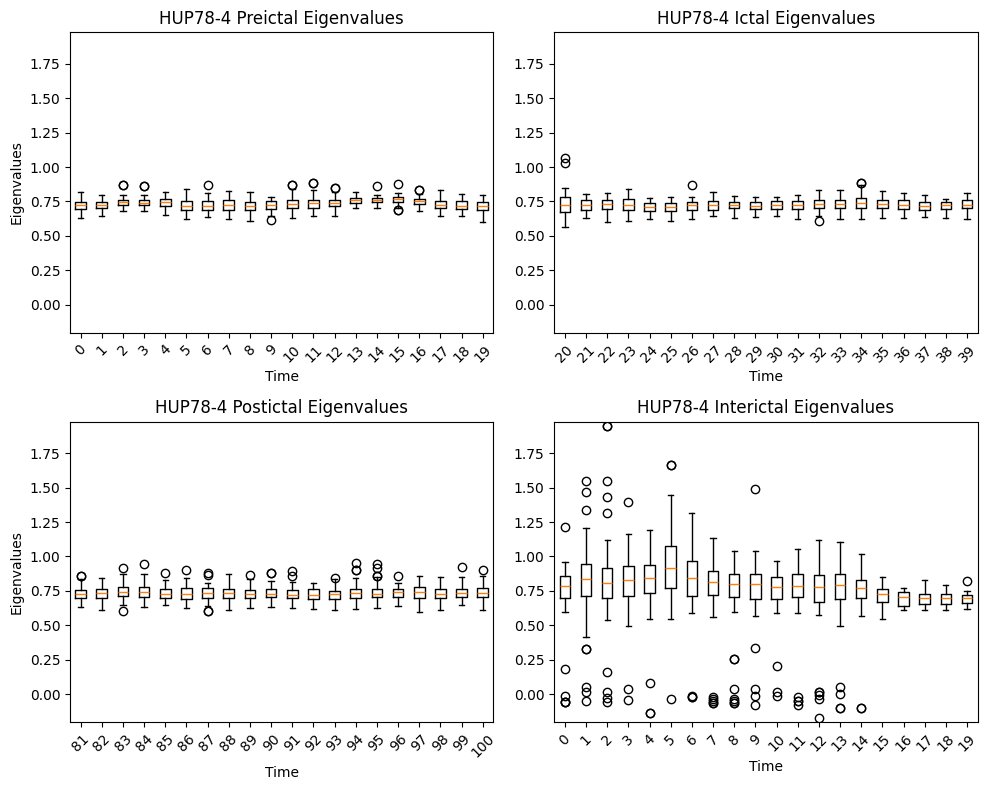

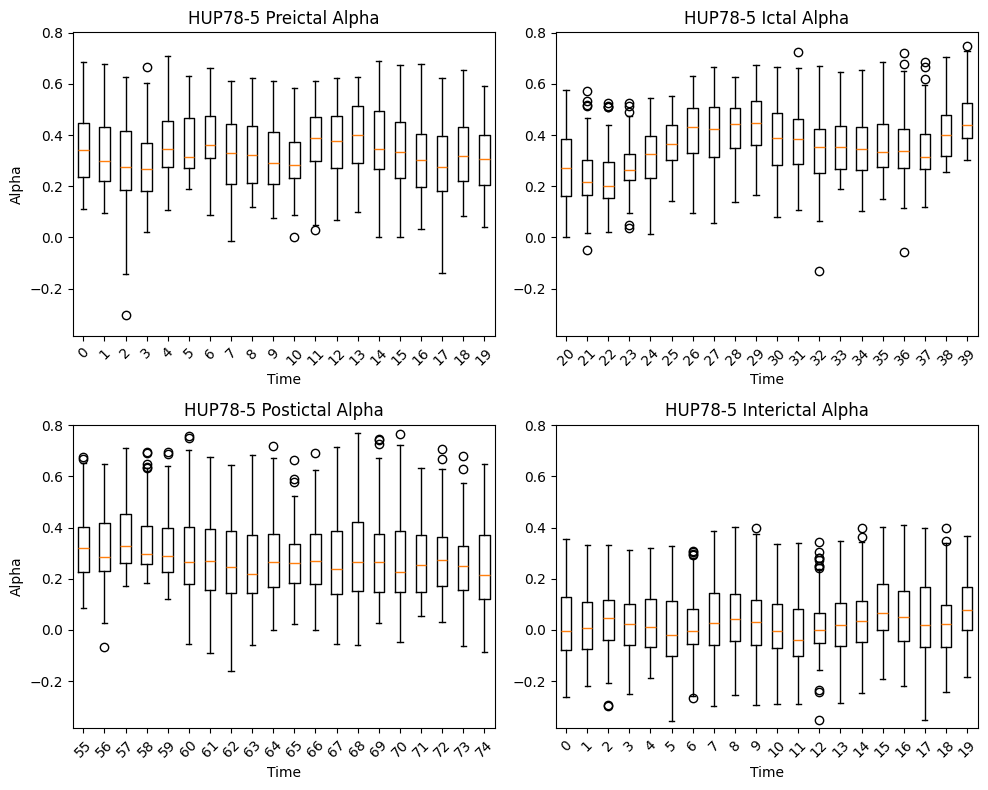

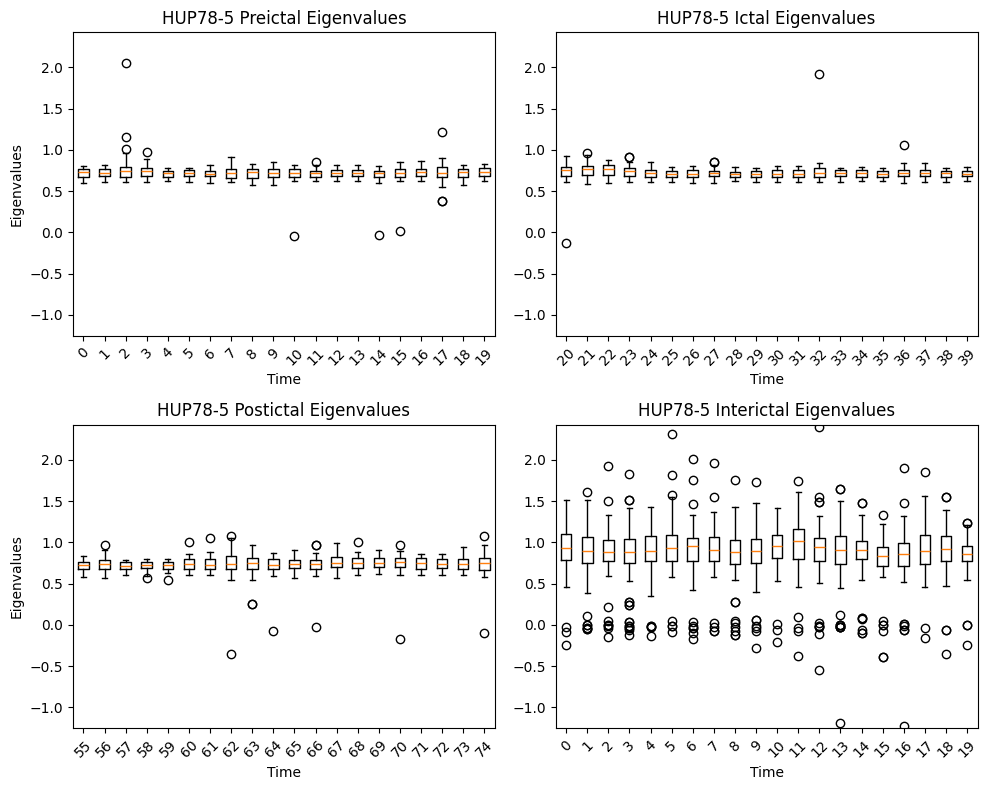

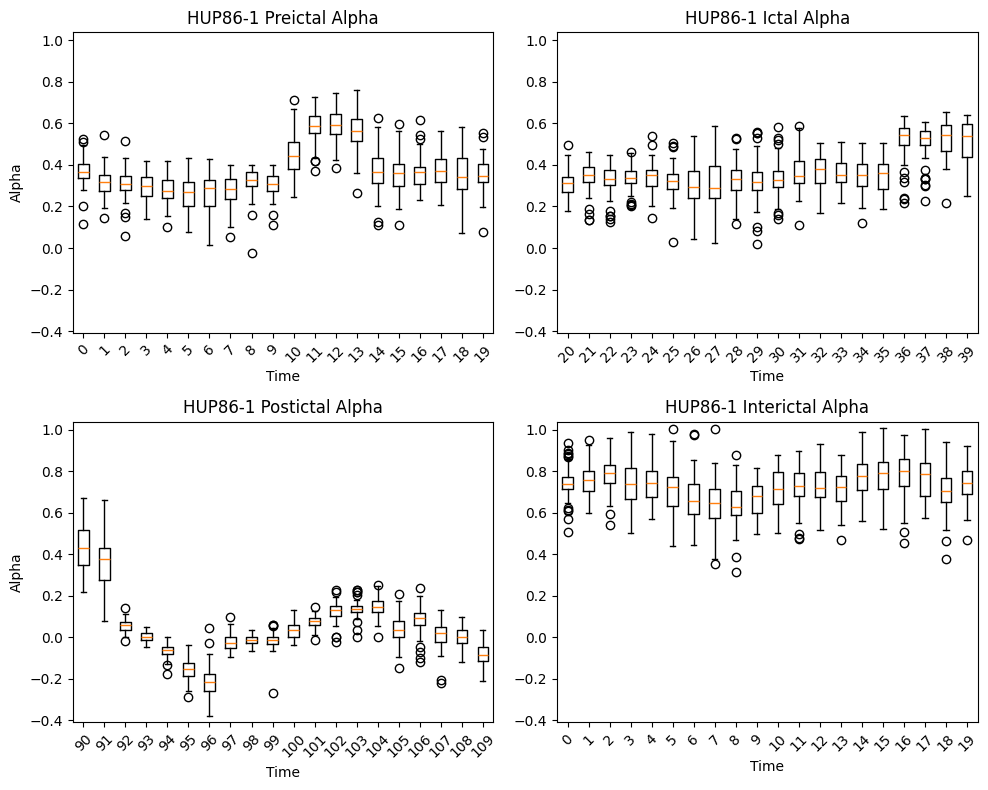

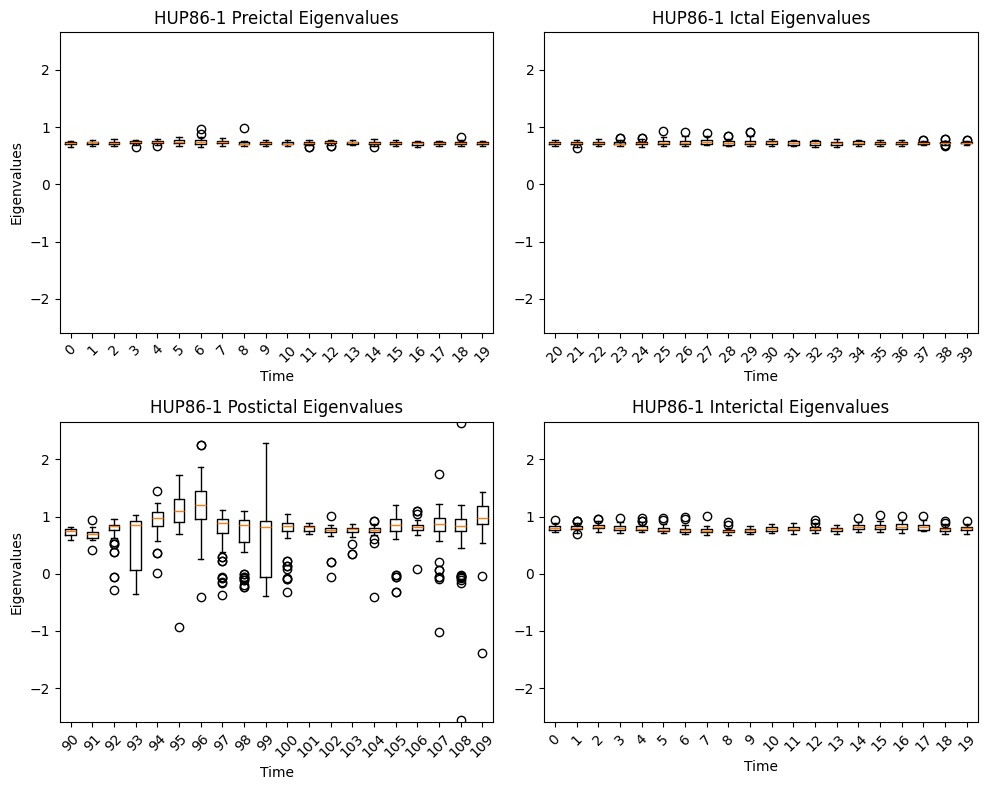

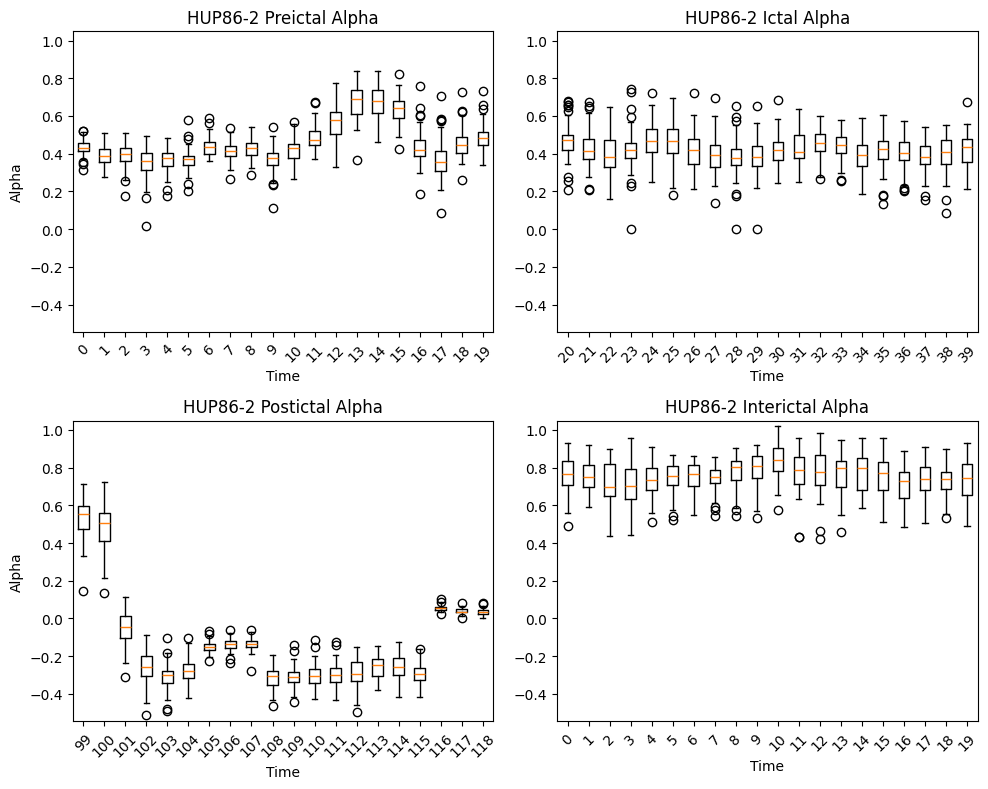

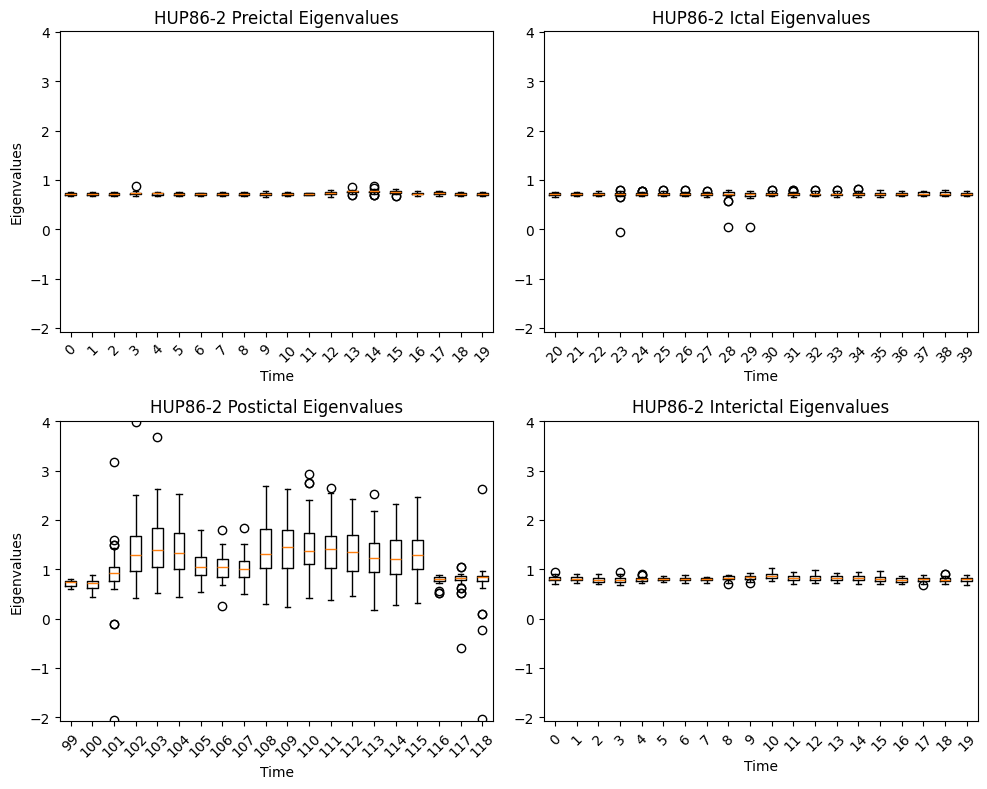

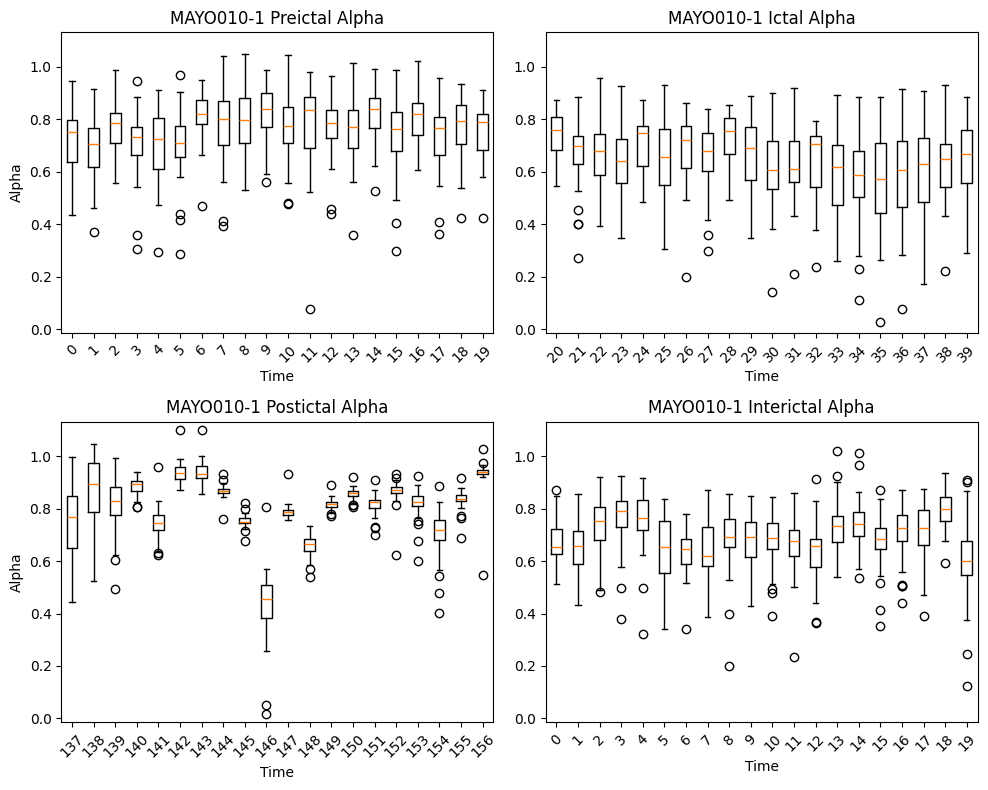

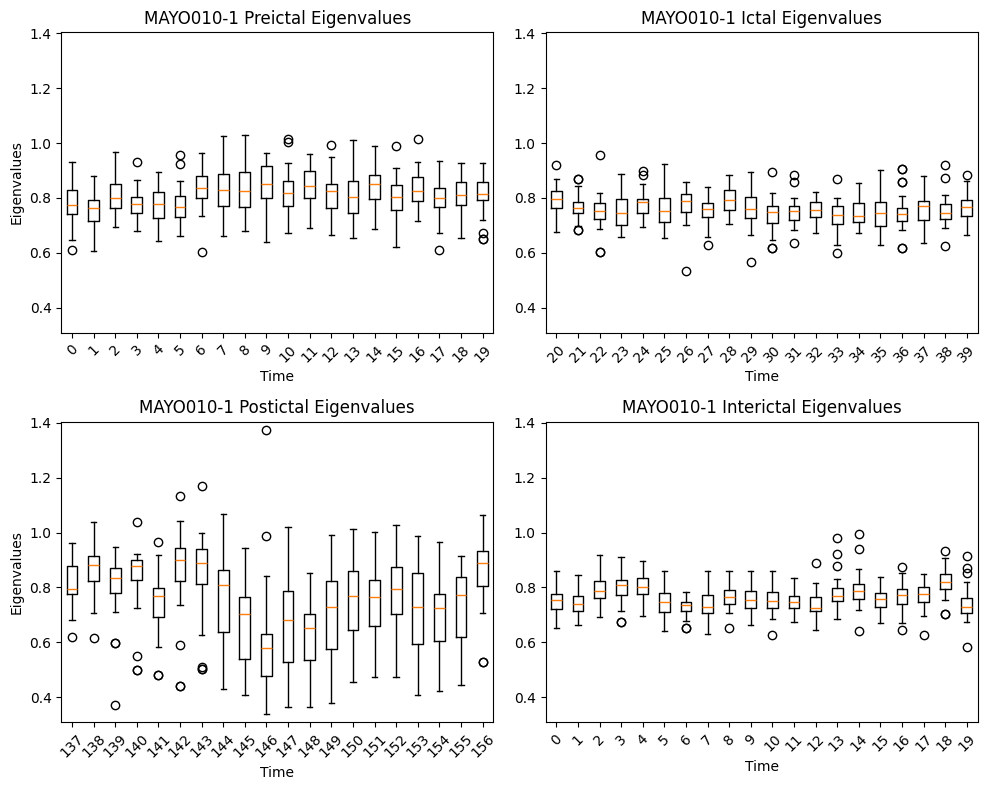

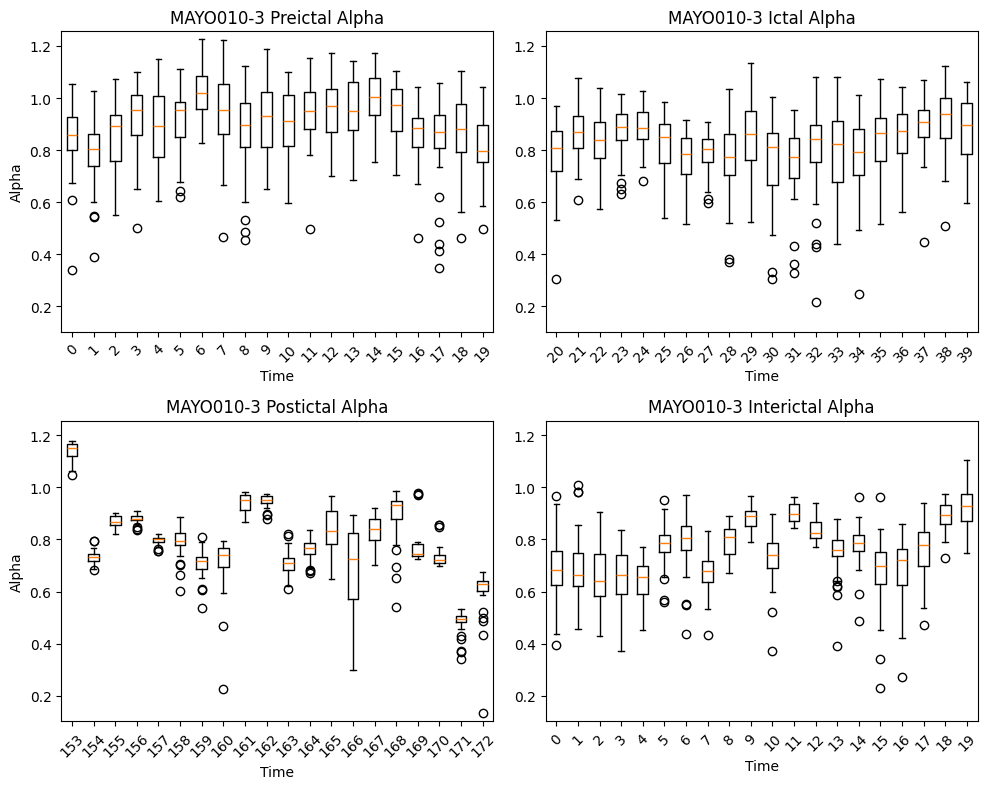

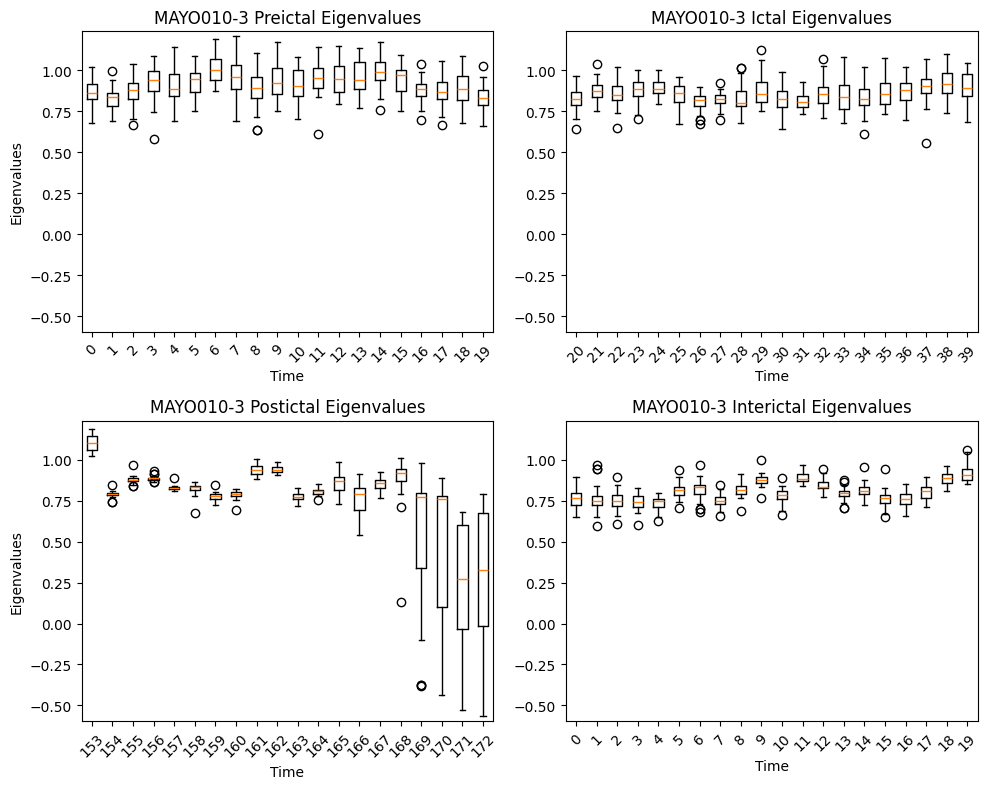

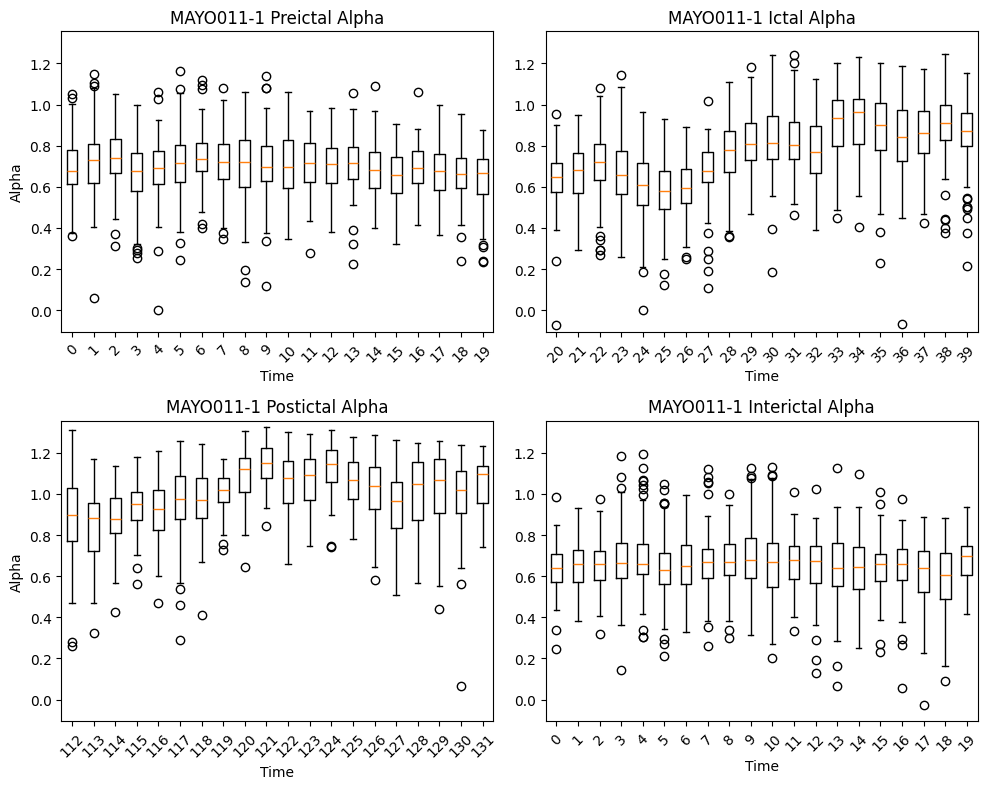

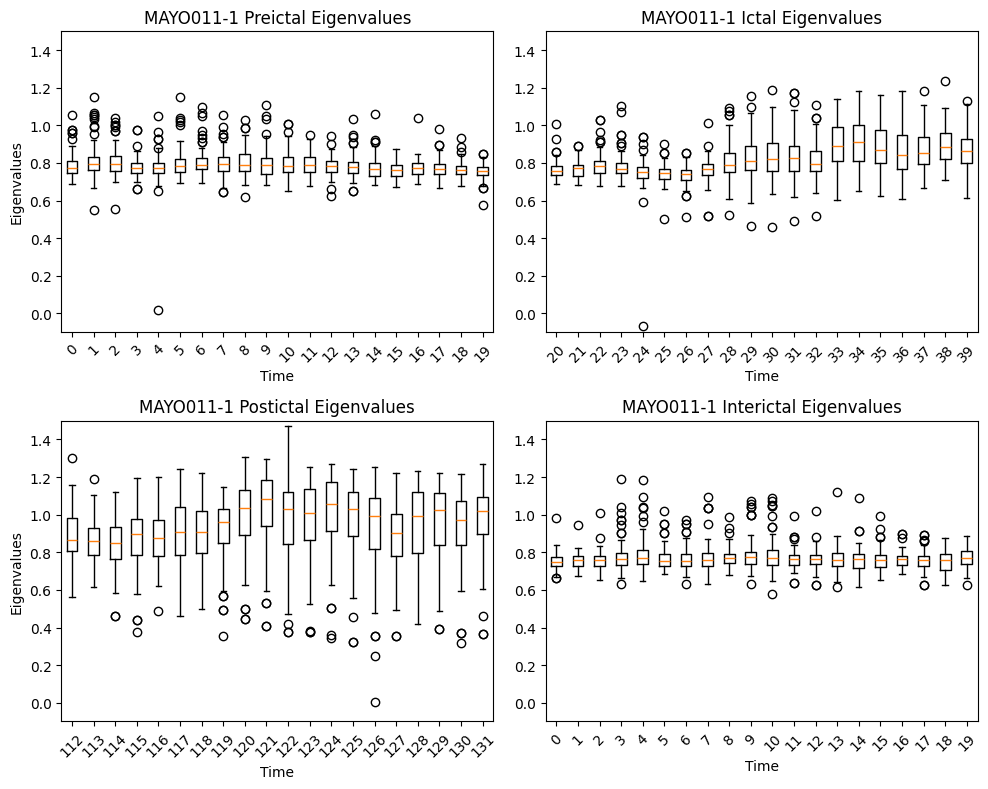

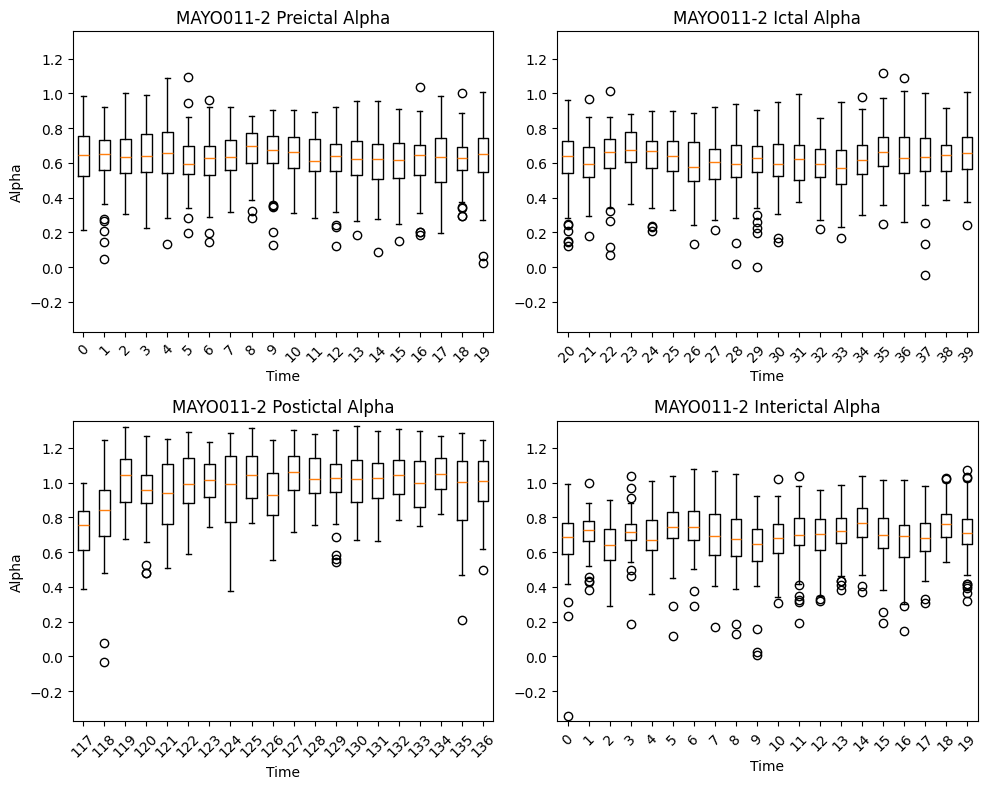

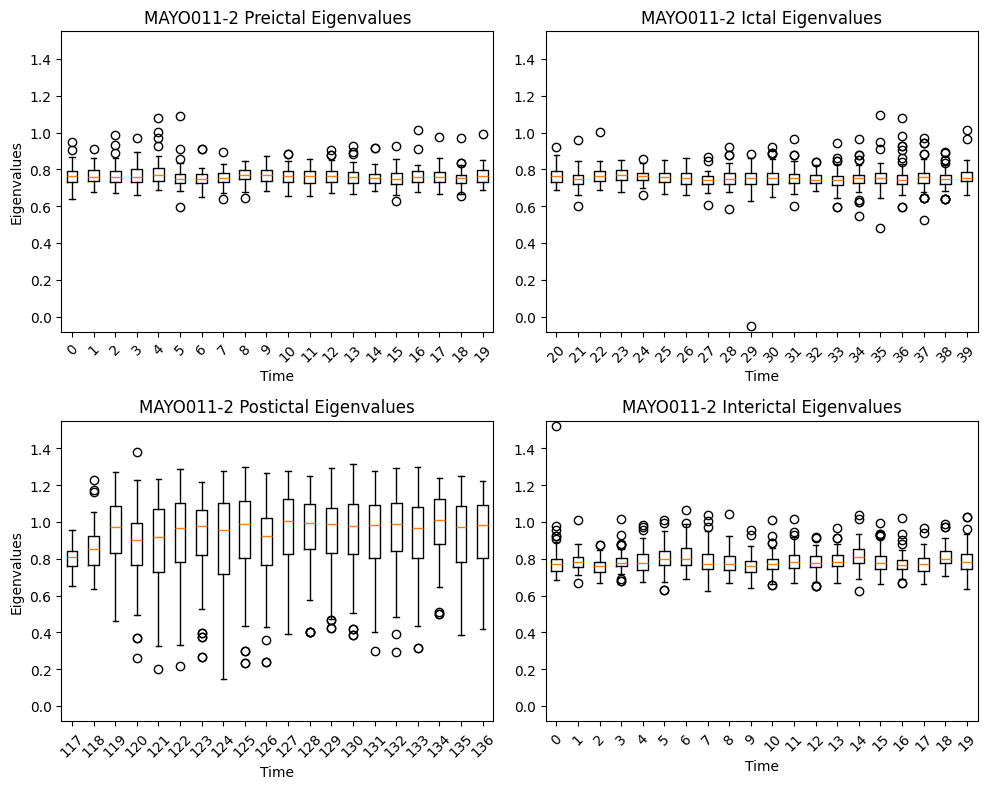

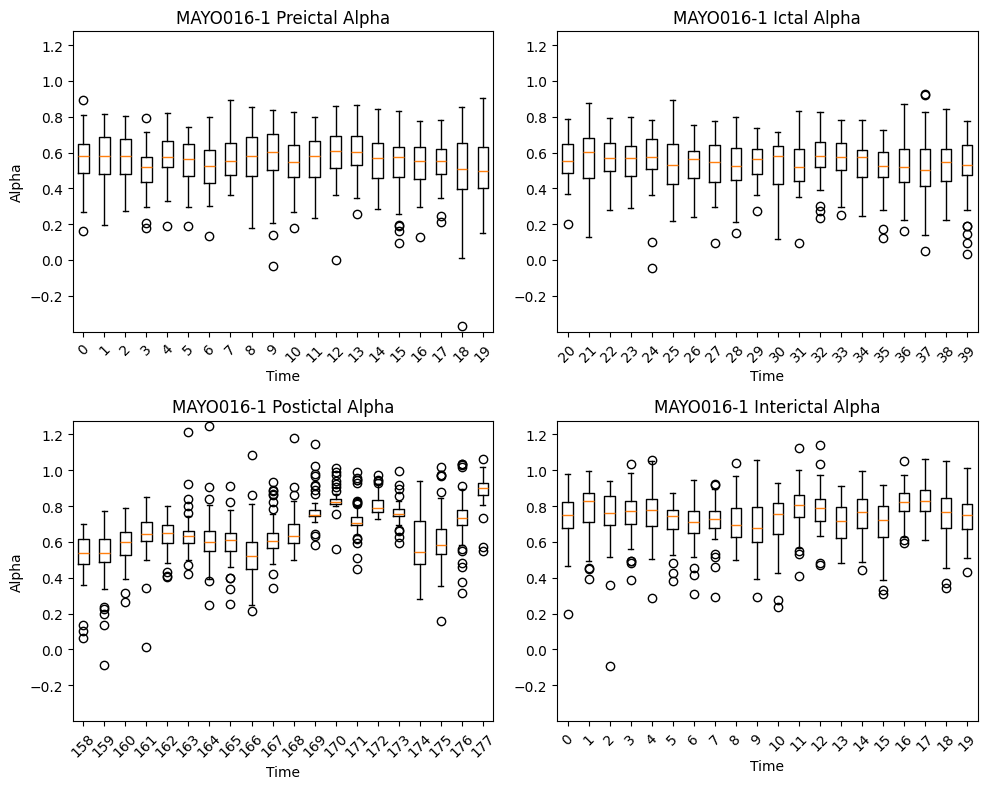

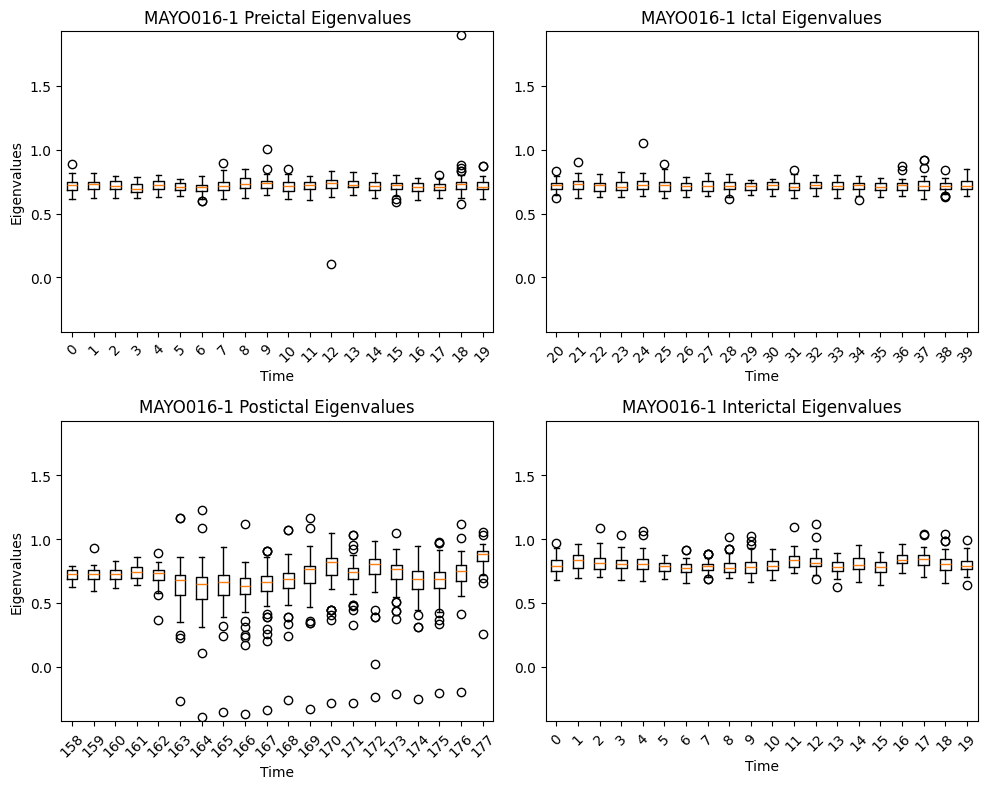

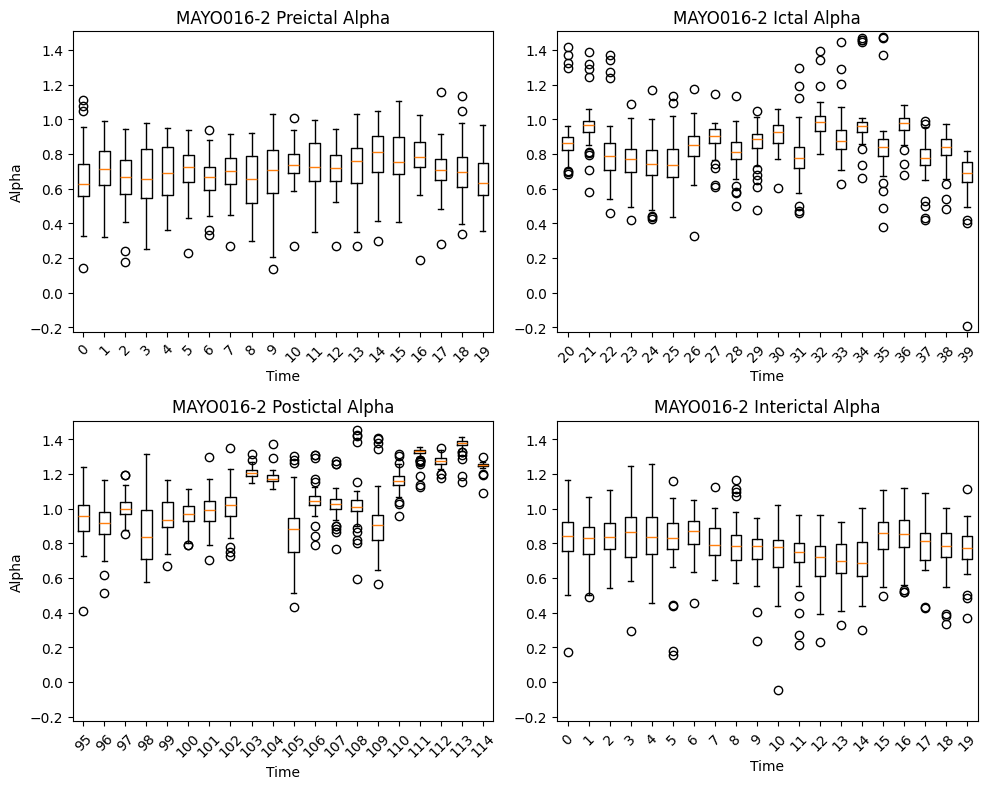

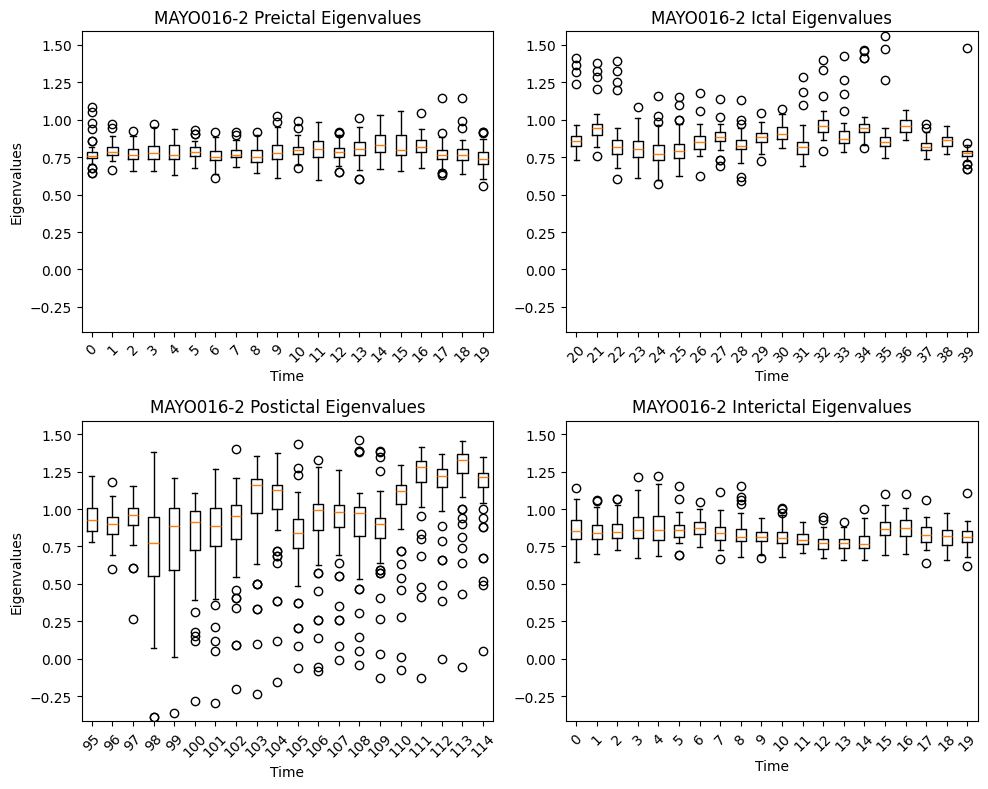

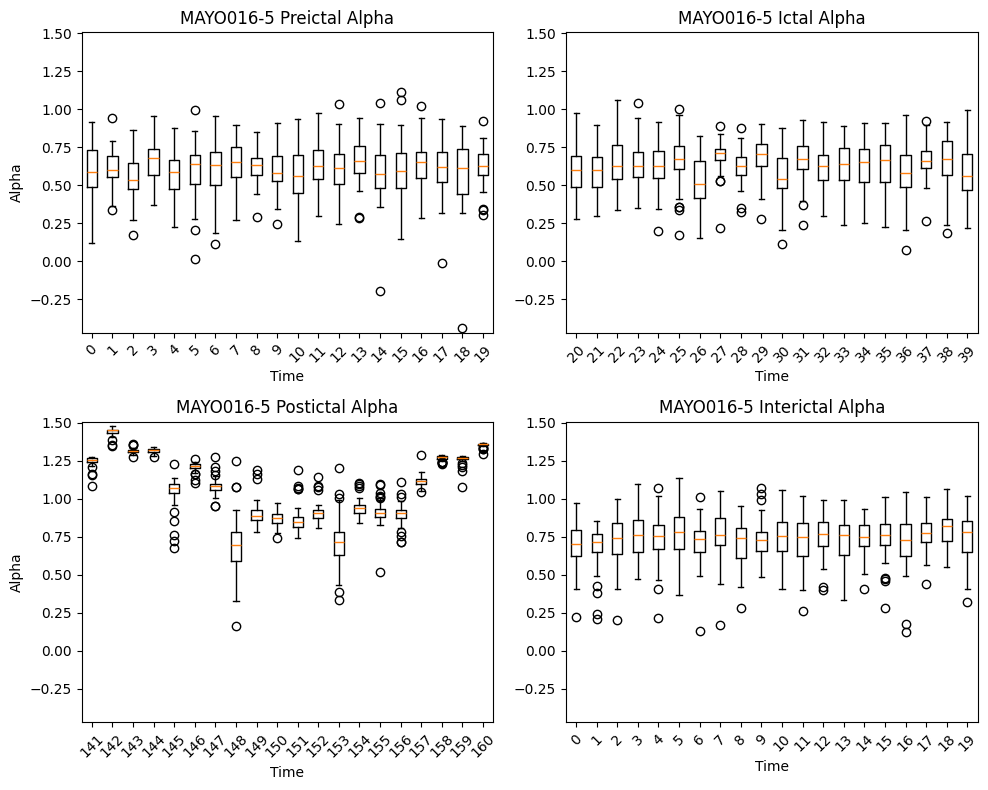

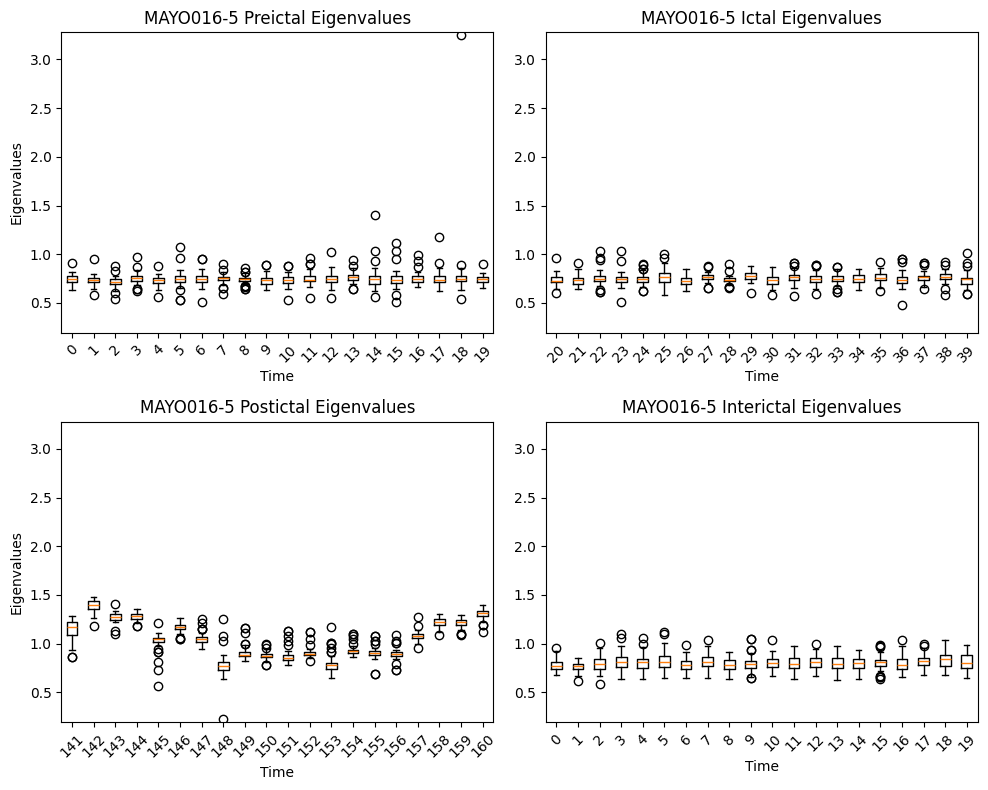

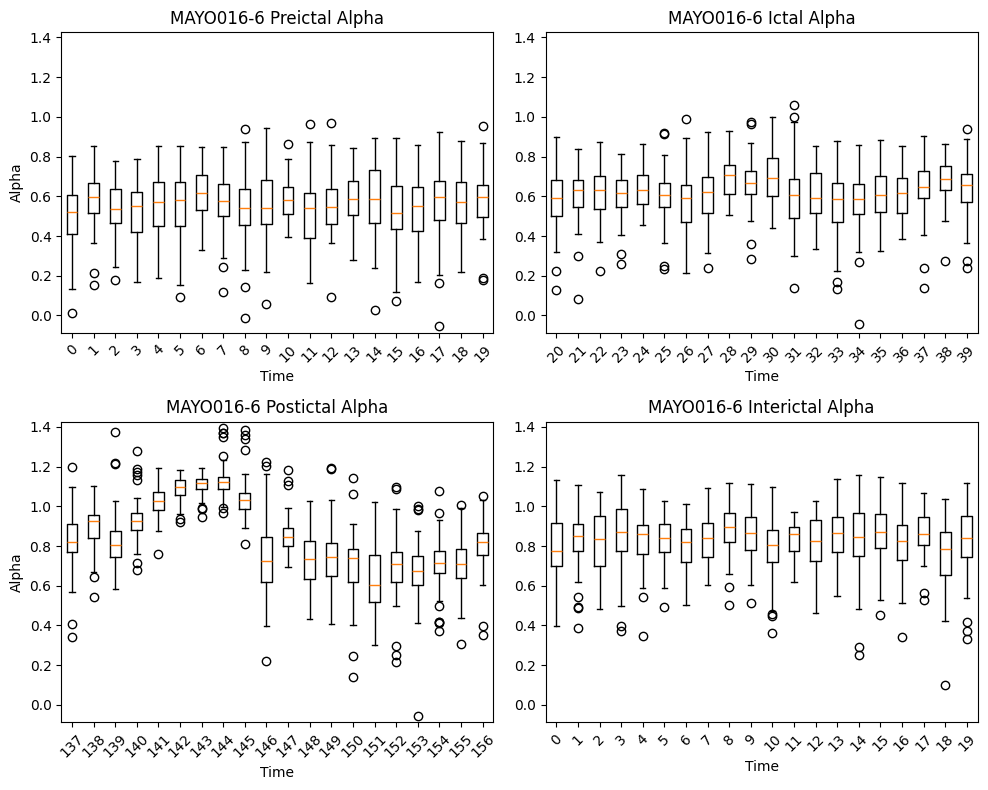

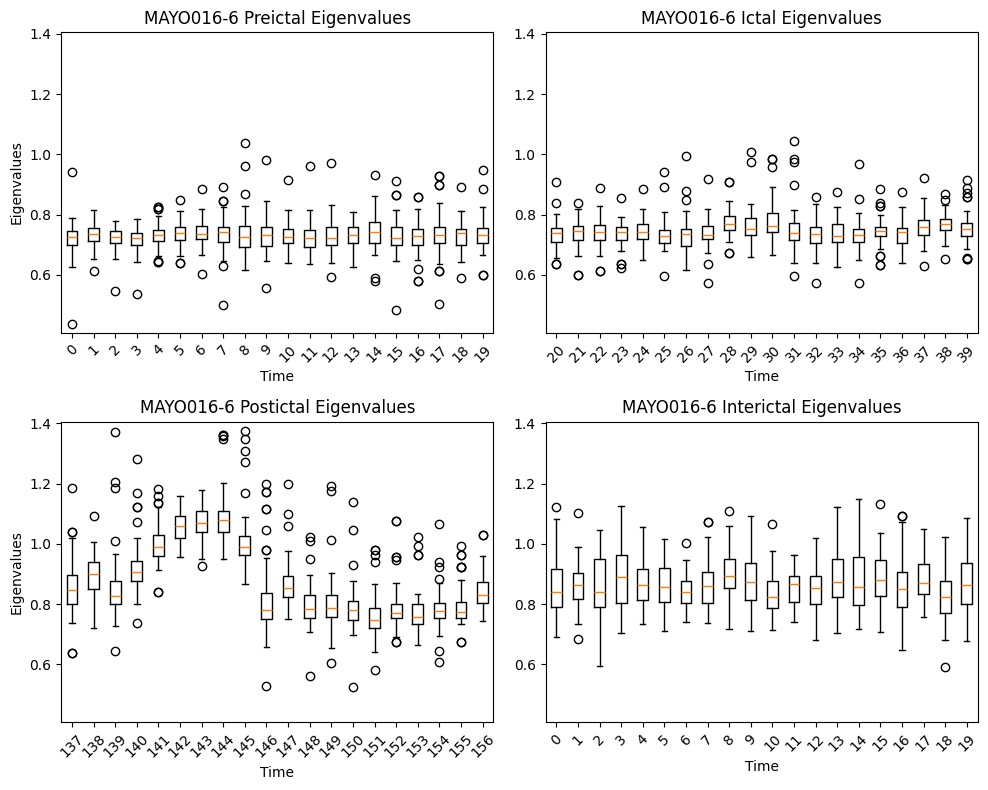

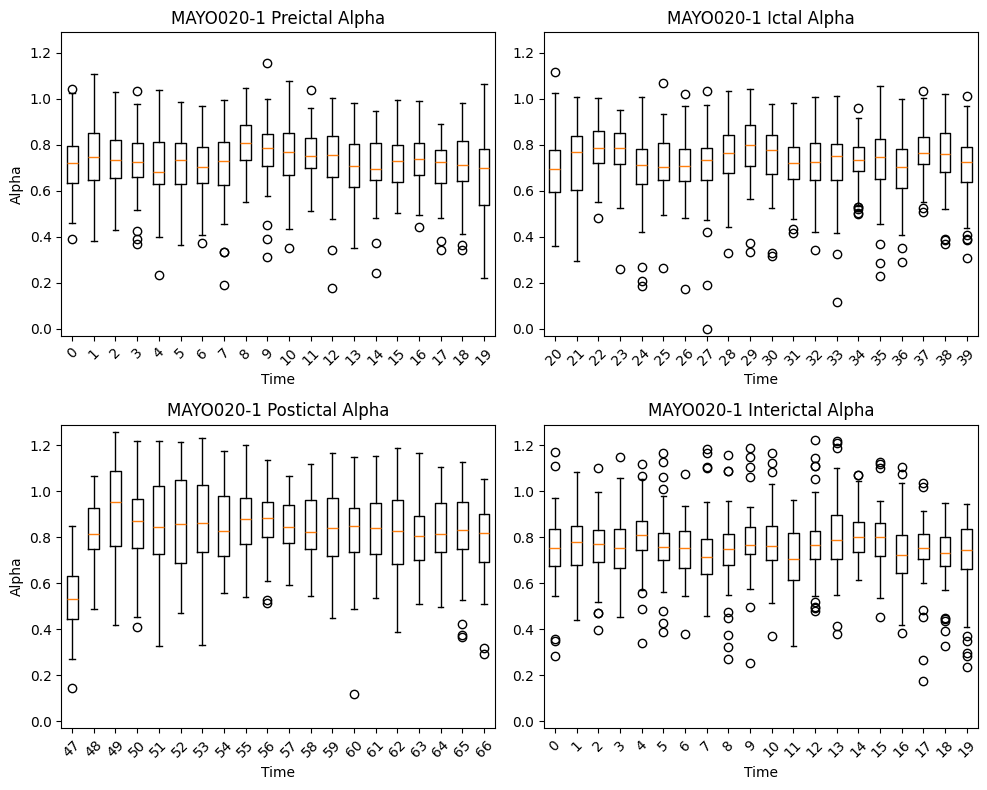

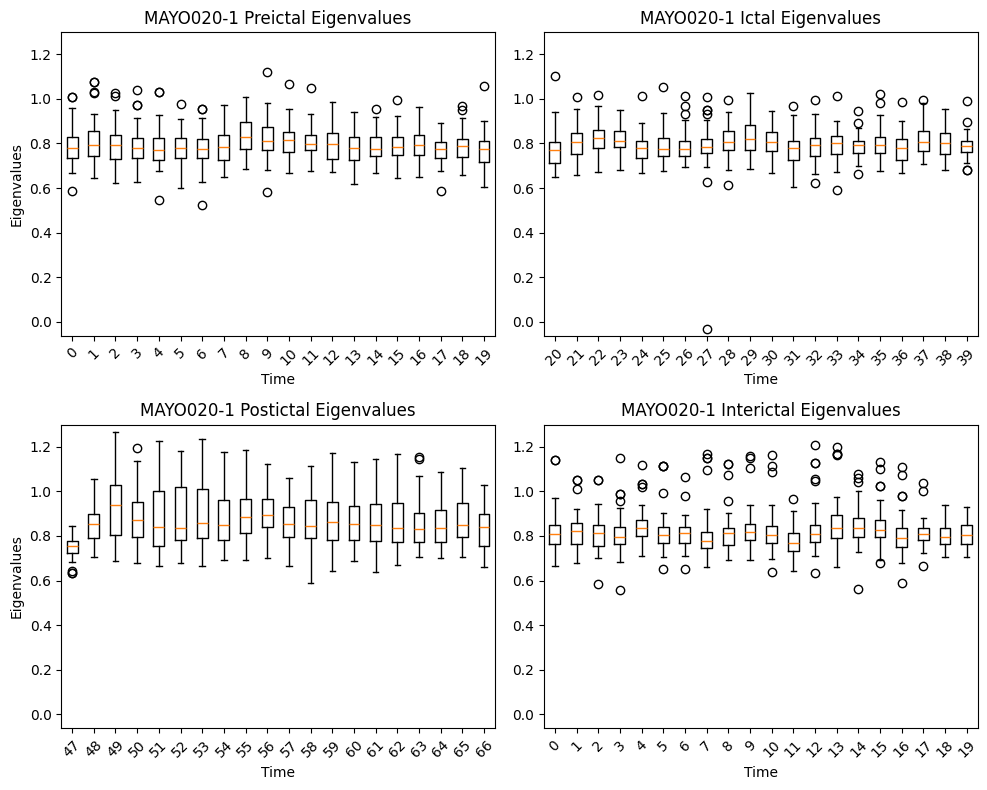

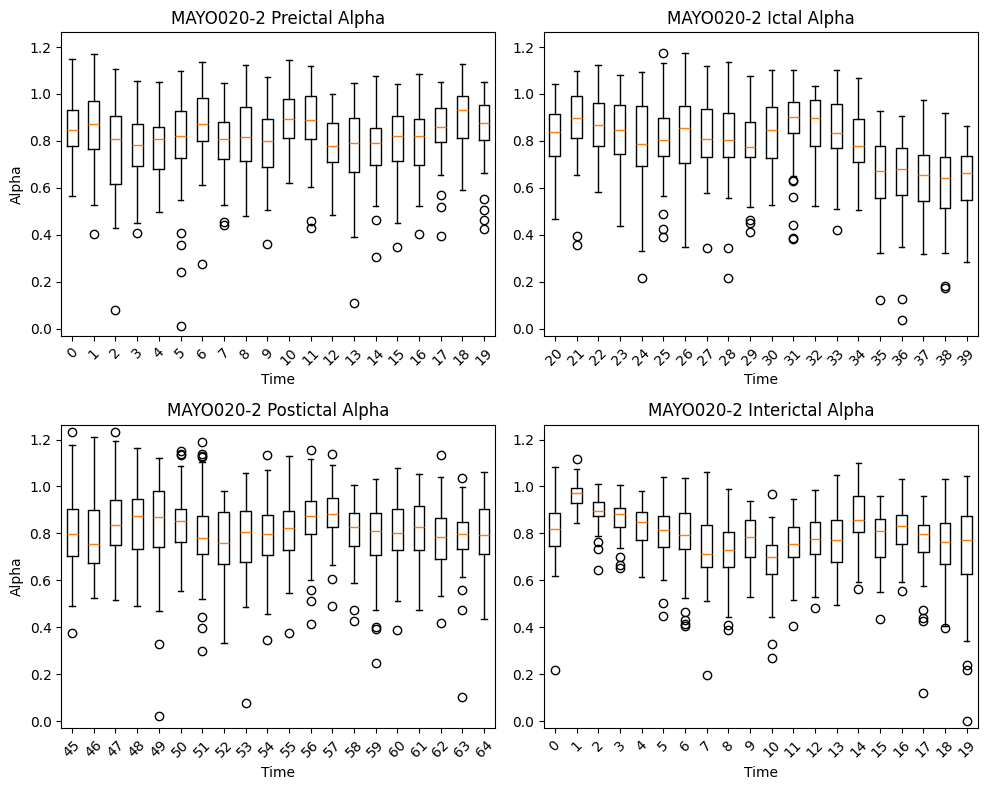

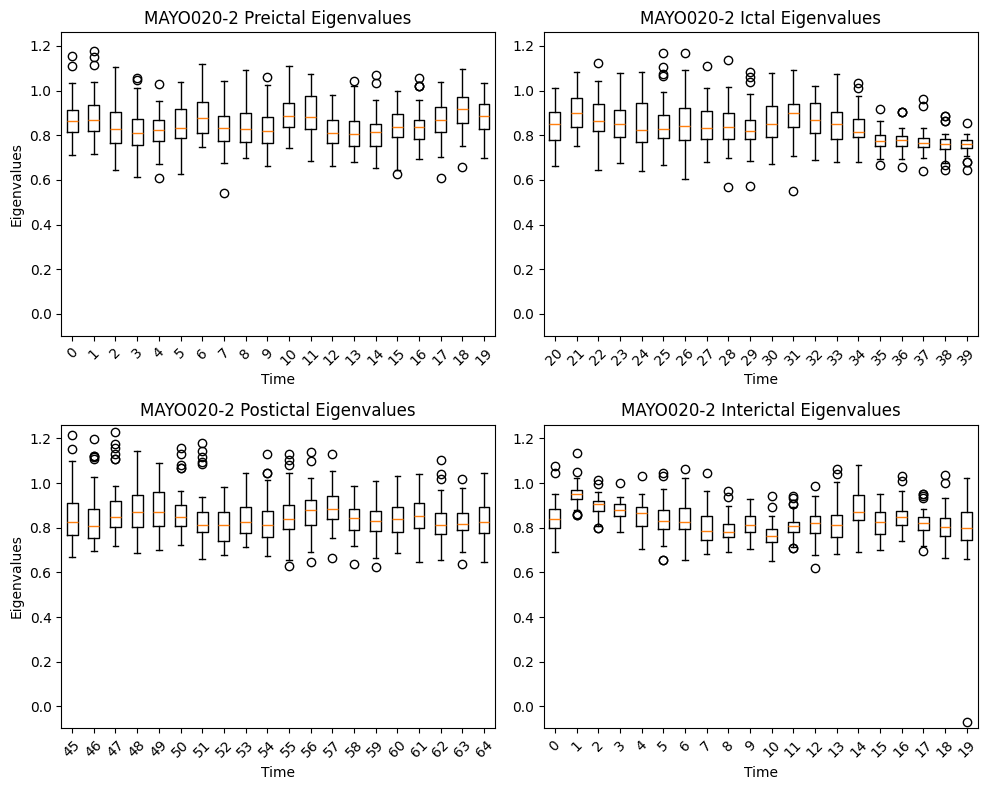

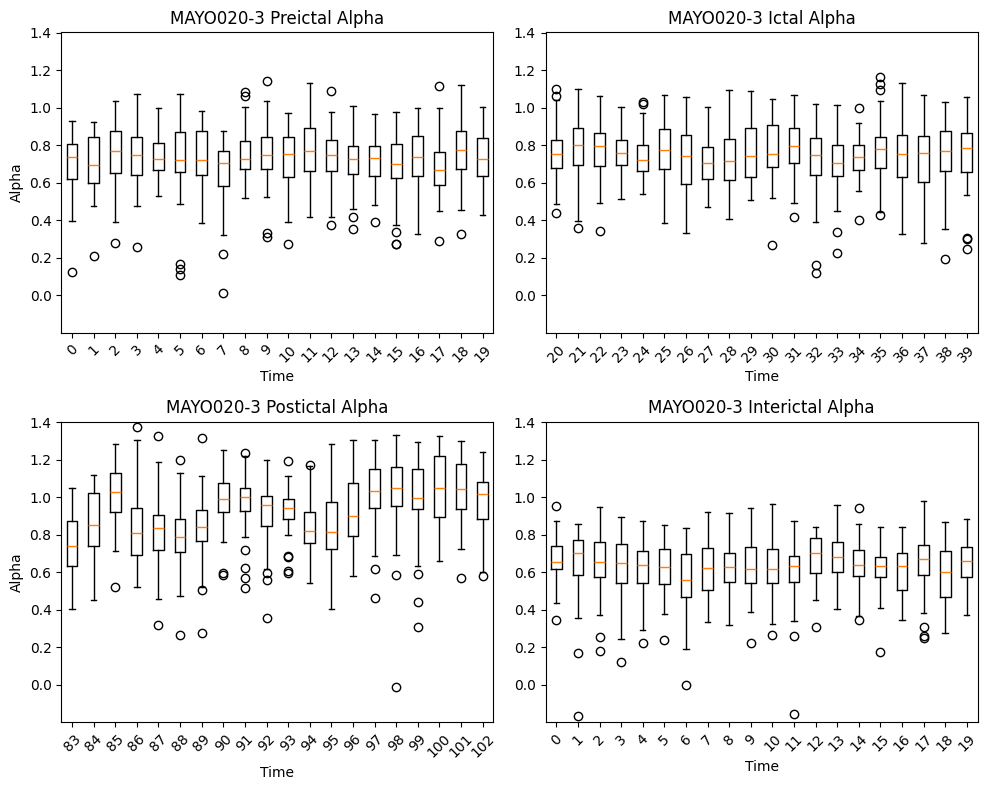

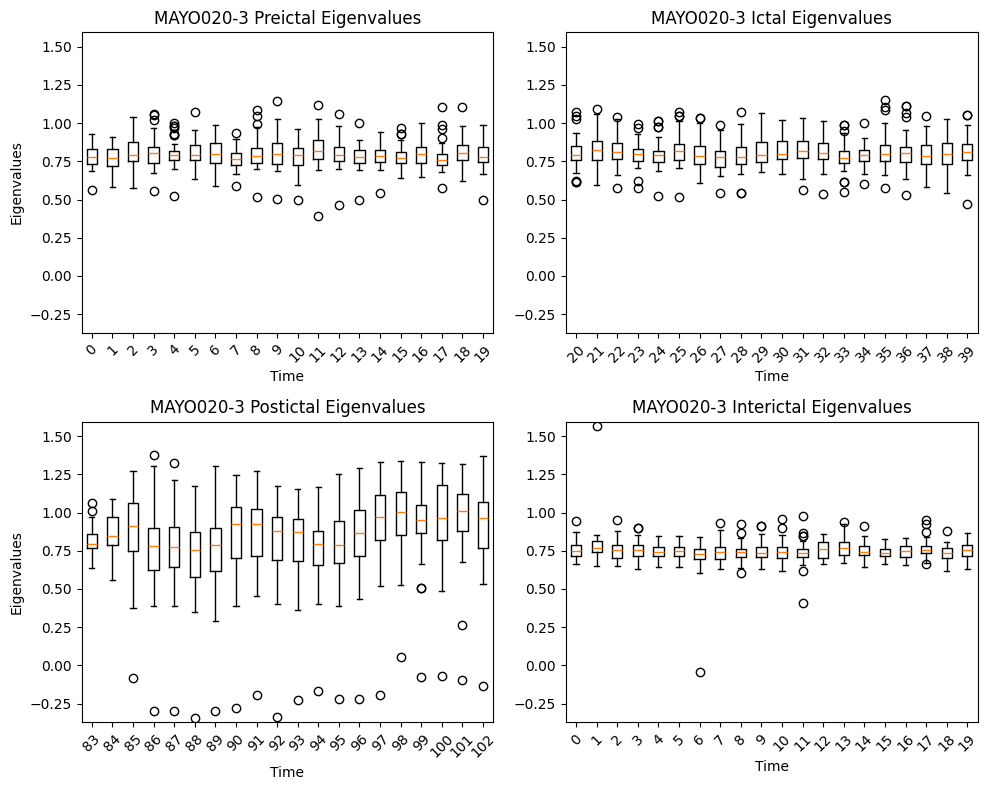

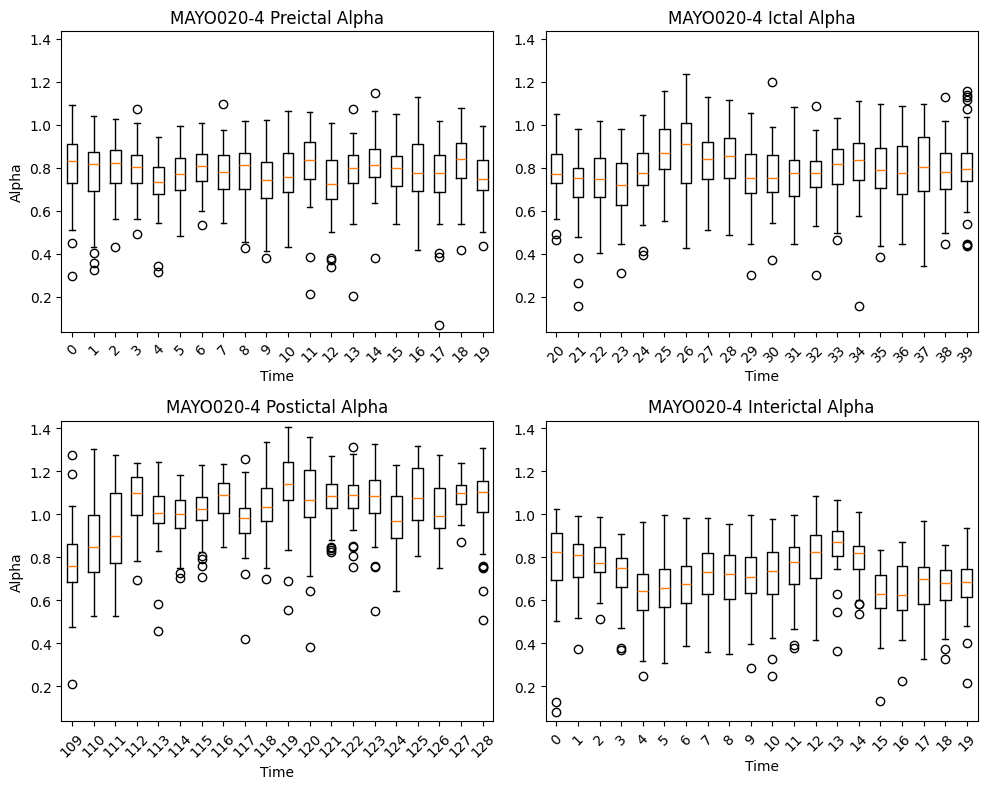

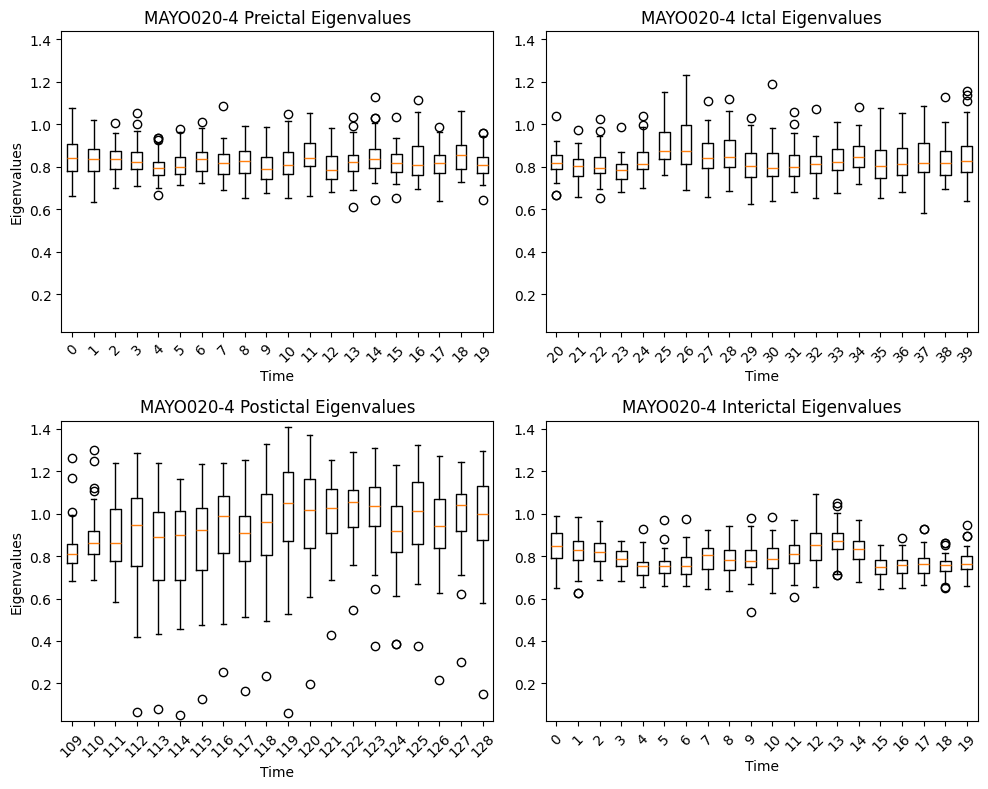

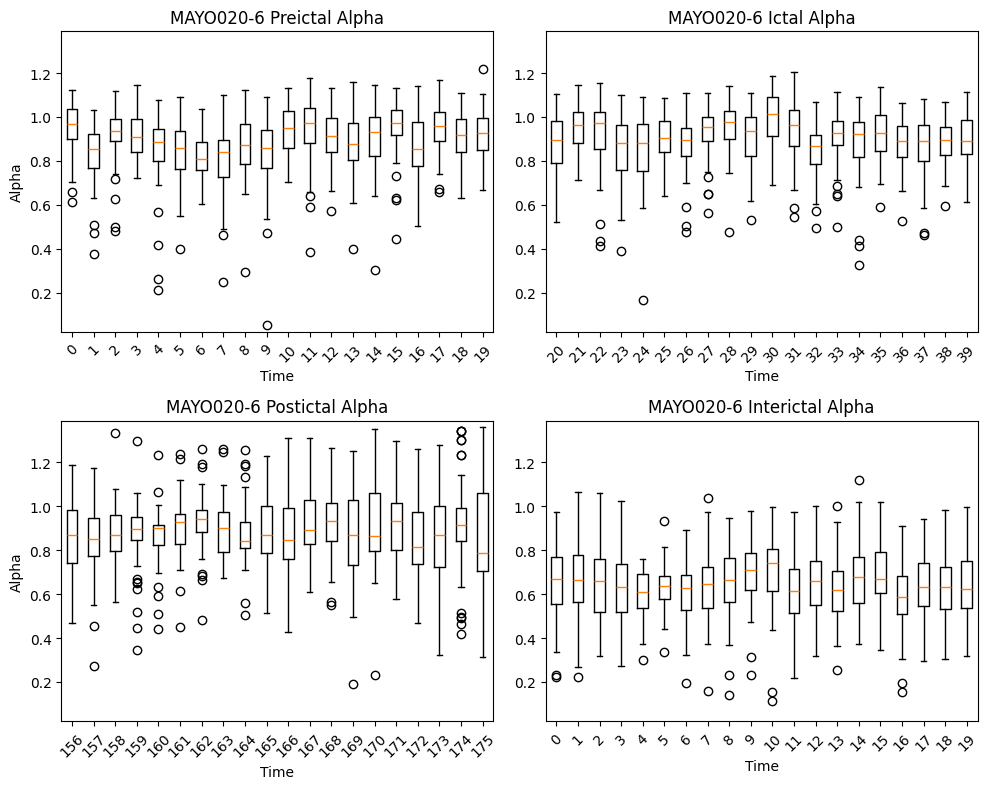

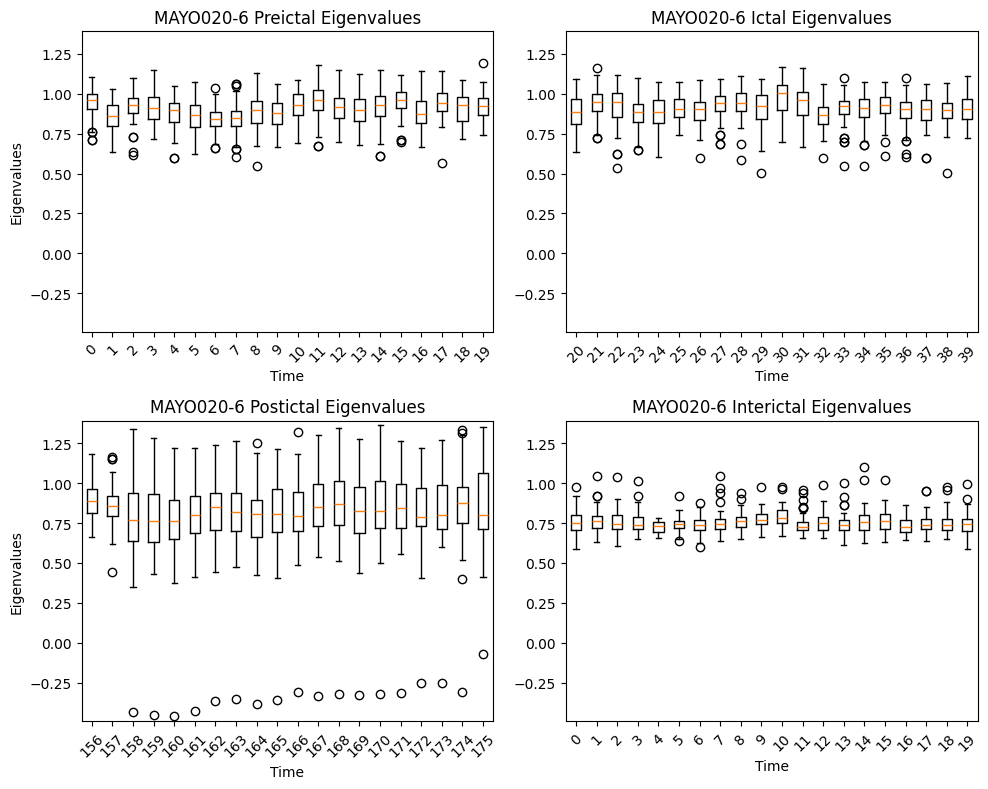

In [ ]:
# patients = ['HUP64', 'HUP68','HUP70','HUP72','HUP78','HUP86','MAYO010','MAYO011','MAYO016','MAYO020']
# patients = ['HUP78']
patients = ['HUP64', 'HUP68','HUP72','HUP78','HUP86','MAYO010','MAYO011','MAYO016','MAYO020']

main_pathname = 'c:/Users/yaoyu/Documents/Epilepsy_research/data_v2'

preictal_start = 0
ictal_start = 20 
ictal_end = 40

test_pairs = [
    ('interictal_alpha', 'preictal_alpha'),
    ('interictal_alpha', 'ictal_alpha'),
    ('interictal_alpha', 'postictal_alpha'),
    ('preictal_alpha', 'ictal_alpha'),
    ('ictal_alpha', 'postictal_alpha'),
    
    ('interictal_eigen', 'preictal_eigen'),
    ('interictal_eigen', 'ictal_eigen'),
    ('interictal_eigen', 'postictal_eigen'),
    ('preictal_eigen', 'ictal_eigen'),
    ('ictal_eigen', 'postictal_eigen'),
]

def cohens_d(x, y):
    x = np.real(x).astype(np.float64)
    y = np.real(y).astype(np.float64)

    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / dof)

    return (np.mean(x) - np.mean(y)) / pooled_std if pooled_std > 0 else np.nan


results = []

for patient in patients: 
    for seizure in range(1, 9):
        file = os.path.join(main_pathname, patient, f"fos_features_block_{seizure}.npz")
        if(os.path.exists(file)):
            data = np.load(file)

            preictal_alpha = data['preictal_alpha']
            ictal_alpha = data['ictal_alpha']
            postictal_alpha = data['postictal_alpha']
            interictal_alpha = data['interictal_alpha']

            preictal_eigen = np.real(data['preictal_eigen']).astype(float)
            ictal_eigen = np.real(data['ictal_eigen']).astype(float)
            postictal_eigen = np.real(data['postictal_eigen']).astype(float)
            interictal_eigen = np.real(data['interictal_eigen']).astype(float)
            
            timepoints_post_ictal = data['timepoints']
            all_alpha = np.concatenate([preictal_alpha, ictal_alpha, postictal_alpha, interictal_alpha])

            ymin = np.min(all_alpha)
            ymax = np.max(all_alpha)
            fig, axs = plt.subplots(2, 2, figsize=(10, 8))
            
            for ax in axs.flat:
                ax.set_ylim(ymin-.03, ymax+.03)
                ax.tick_params(axis='x', labelrotation=45)
            
            axs[0, 0].boxplot(preictal_alpha, positions = list(range(preictal_start, ictal_start)))
            axs[0, 0].set_title(f"{patient}-{seizure} Preictal Alpha")
            axs[0, 0].set_xlabel("Time")
            axs[0, 0].set_ylabel("Alpha")

            axs[0, 1].boxplot(ictal_alpha, positions = list(range(ictal_start, ictal_end)))
            axs[0, 1].set_title(f"{patient}-{seizure} Ictal Alpha")
            axs[0, 1].set_xlabel("Time")

            axs[1, 0].boxplot(postictal_alpha, positions = timepoints_post_ictal)
            axs[1, 0].set_title(f"{patient}-{seizure} Postictal Alpha")
            axs[1, 0].set_xlabel("Time")
            axs[1, 0].set_ylabel("Alpha")

            axs[1, 1].boxplot(interictal_alpha, positions = list(range(0, 20)))
            axs[1, 1].set_title(f"{patient}-{seizure} Interictal Alpha")
            axs[1, 1].set_xlabel("Time")

            plt.tight_layout()
            plt.show()
            plt.close()

            all_eigen = np.concatenate([preictal_eigen, ictal_eigen, postictal_eigen, interictal_eigen])

            ymin = np.min(all_eigen)
            ymax = np.max(all_eigen)
            fig, axs = plt.subplots(2, 2, figsize=(10, 8))
            
            for ax in axs.flat:
                ax.set_ylim(ymin-.03, ymax+.03)
                ax.tick_params(axis='x', labelrotation=45)
            axs[0, 0].boxplot(preictal_eigen, positions = list(range(preictal_start, ictal_start)))
            axs[0, 0].set_title(f"{patient}-{seizure} Preictal Eigenvalues")
            axs[0, 0].set_xlabel("Time")
            axs[0, 0].set_ylabel("Eigenvalues")

            axs[0, 1].boxplot(ictal_eigen, positions = list(range(ictal_start, ictal_end)))
            axs[0, 1].set_title(f"{patient}-{seizure} Ictal Eigenvalues")
            axs[0, 1].set_xlabel("Time")

            axs[1, 0].boxplot(postictal_eigen, positions = timepoints_post_ictal)
            axs[1, 0].set_title(f"{patient}-{seizure} Postictal Eigenvalues")
            axs[1, 0].set_xlabel("Time")
            axs[1, 0].set_ylabel("Eigenvalues")

            axs[1, 1].boxplot(interictal_eigen, positions = list(range(0, 20)))
            axs[1, 1].set_title(f"{patient}-{seizure} Interictal Eigenvalues")
            axs[1, 1].set_xlabel("Time")

            plt.tight_layout()
            plt.show()
            plt.close()

            features = {
                'preictal_alpha': preictal_alpha,
                'ictal_alpha': ictal_alpha,
                'postictal_alpha': postictal_alpha,
                'interictal_alpha': interictal_alpha,
                'preictal_eigen': preictal_eigen,
                'ictal_eigen': ictal_eigen,
                'postictal_eigen': postictal_eigen,
                'interictal_eigen': interictal_eigen
            }

            for seg1, seg2 in test_pairs:
                x = features[seg1].flatten()
                y = features[seg2].flatten()
                ks_stat, p_val = ks_2samp(x, y)
                d_val = cohens_d(x, y)

                results.append({
                    'patient': f'{patient}-block-{seizure}',
                    'feature': 'alpha' if 'alpha' in seg1 else 'eigen',
                    'comparison': (
                        f'{seg1.replace("_alpha", "").replace("_eigen", "").replace("_", " ")} '
                        f'vs {seg2.replace("_alpha", "").replace("_eigen", "").replace("_", " ")}'
                    ),
                    'KS_stat': np.round(ks_stat, 3),
                    'p_value': np.round(p_val, 4),
                    'cohen_d': np.abs(np.round(d_val, 3))
                })
                
# df = pd.DataFrame(results)
# df.to_csv("pairwise_comparison_results.csv", index=False)          